<a href="https://colab.research.google.com/github/ATOMconsortium/AMPL/blob/master/atomsci/ddm/examples/tutorials/07_EDA_With_Harmonization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis

In this notebook we will analyze molecular data and assay measurements for datasets collected from ChEMBL, Drug Target Commons (DTC) and Excape-DB.
1. ***COPY*** this notebook into your own google drive. Work and edit from that copy.
2. For this tutorial, we will use HTR3A target (https://www.ncbi.nlm.nih.gov/gene/3359) binding data from three different data sources, DTC, Excape-DB and ChEMBL. *If you want to use your own target, you can download your target related data from the following databases*:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/


# Scope of the tutorial:

*   Load the datasets
*   Clean and examine the data
*   Merge the datasets
*   Examine compound diversity
*   Create curated data 
*   Store the ML ready data (in Google Drive) for modeling

## Time on COLAB-Pro (~ 6 minutes)

## Mount your drive and decide on a **folder** in your drive where you can save the data. For example, we call the folder as **AMPL_EDA_07**

In [1]:
!date

Tue Aug 10 18:10:13 UTC 2021


## When you run the following cell, you will be asked to give permission for Google to mount your Google-drive. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Install packages** 

In [ ]:
! pip install rdkit-pypi
! pip install --pre deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install llvmlite==0.35.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

# Load Libraries

In [5]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# manipulate data
import pandas as pd

import json
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

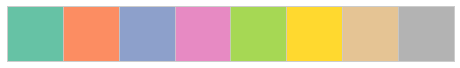

In [6]:
sns.palplot(pal)

In [7]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

# Download/Load data

In [ ]:
! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/A-HTR3A/HTR3A_DTC.csv
! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/A-HTR3A/HTR3A_Excape.csv
! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/A-HTR3A/HTR3A_ChEMBL.csv

# Explore and examine **data**

In [9]:
dtc = pd.read_csv("HTR3A_DTC.csv", sep=',', header=0 )
excape = pd.read_csv("HTR3A_Excape.csv", sep=',', header=0)
chembl = pd.read_csv("HTR3A_ChEMBL.csv", sep=',', header=0 )

In [10]:
dtc.iloc[1:3,1:10]

Uniprot ID Compound Name           Standard inchi key  Max Phase  \
1     P46098           NaN  SCDKHPSUXHBJDJ-UHFFFAOYSA-N          0   
2     P46098           NaN  WGIPGQAPFNVWIX-XXFZXMJFSA-N          0   

                 Target Pref Name Gene Names Target Class  \
1  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
2  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   

   Wild type or mutant  Mutation information  
1                  NaN                   NaN  
2                  NaN                   NaN

In [11]:
excape.iloc[1:3, 1:15]

Original_Entry_ID  Entrez_ID Activity_Flag    pXC50        DB  \
1      CHEMBL494999      79246             A  7.36000  chembl20   
2          44157937      79246             A  8.52288   pubchem   

   Original_Assay_ID  Tax_ID Gene_Symbol  Ortholog_Group  \
1             523350   10116       HTR3A            2102   
2             375321   10116       HTR3A            2102   

                                              SMILES  
1  N=1C=2C=CC=C(C)C2N3C(=CC=C3)C1N4CCN(CC4)C(C(=O...  
2   OC(=NO)CN1CCN(CC1)C2=NC=3C(N4C2=CC=C4)=C(C=CC3)C

In [12]:
chembl.iloc[1:3, 1:10]

Molecule Name  Molecule Max Phase Molecular Weight #RO5 Violations  AlogP  \
1       GLYCINE                   4            75.07               0  -0.97   
2           NaN                   0           312.37               0   0.88   

  Compound Key                                           Smiles Standard Type  \
1      glycine                                         NCC(=O)O          EC50   
2            9  O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   

  Standard Relation  
1               NaN  
2               '='

## **Examine and clean data** 
- What molecular (and other) identifiers exist for compounds from each database?
- What assay response types are there in each file?
- Think about how we might combine these data sources together

In [13]:
# get rid of spaces
chembl.columns = chembl.columns.str.replace(' ','_') 
dtc.columns = dtc.columns.str.replace(' ','_') 
excape.columns = excape.columns.str.replace(' ','_') 

print(chembl.shape)
print(dtc.shape)
print(excape.shape)

(1950, 45)
(1310, 43)
(649, 11)


### Questions to ask while exploring data

- what molecular (and other) identifiers exist for compounds from each database?
- what assay response types are there in each file?
- think about how we might combine these data sources together

## ChEMBL: Explore `dataset`

In [14]:
chembl.head()

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase Molecular_Weight  \
0      CHEMBL3233676           NaN                   0           622.85   
1          CHEMBL773       GLYCINE                   4            75.07   
2      CHEMBL3261486           NaN                   0           312.37   
3      CHEMBL3943065           NaN                   0           401.47   
4      CHEMBL2086584           NaN                   0           427.55   

  #RO5_Violations  AlogP Compound_Key  \
0               2   6.84          22a   
1               0  -0.97      glycine   
2               0   0.88            9   
3               0   2.21   BDBM221658   
4               0   2.99           27   

                                              Smiles Standard_Type  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...    Inhibition   
1                                           NCC(=O)O          EC50   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   
3   CN1C2COCC1CC(NC(=O)c1cn(-c3cscn3)c3ncc(F)cc13)C2          IC50   
4  COc1ccc(-c2cc(NC(=O)C(C)CCCN3CCCN(C(C)=O)CC3)[...          IC50   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='           13.75              %            NaN   
1               NaN             NaN            NaN            NaN   
2               '='           83.00              %            NaN   
3               '='            1.81             nM           8.74   
4               '>'        30000.00             nM            NaN   

  Data_Validity_Comment         Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN             NaN  UO_0000187                    NaN   
1                   NaN  Not Determined         NaN                    NaN   
2                   NaN             NaN  UO_0000187                    NaN   
3                   NaN          388070  UO_0000065                  21.78   
4                   NaN             NaN  UO_0000065                    NaN   

  Ligand_Efficiency_LE Ligand_Efficiency_LLE Ligand_Efficiency_SEI  \
0                  NaN                   NaN                   NaN   
1                  NaN                   NaN                   NaN   
2                  NaN                   NaN                   NaN   
3                 0.43                  6.53                  12.1   
4                  NaN                   NaN                   NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL3240658   
1                False    CHEMBL896288   
2                False   CHEMBL3268498   
3                False   CHEMBL3888296   
4                False   CHEMBL2091623   

                                   Assay_Description Assay_Type BAO_Format_ID  \
0  Reversible inhibition of human 5-HT3A expresse...          B   BAO_0000219   
1  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
2  Partial agonist activity at human 5-HT3A recep...          B   BAO_0000219   
3  In Vitro Inhibition of Ca Flux Assay: The 5HT3...          B   BAO_0000219   
4  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
0  cell-based format   Homo sapiens                   None              None   
1  cell-based format   Homo sapiens                   None              None   
2  cell-based format   Homo sapiens                   None              None   
3  cell-based format   Homo sapiens                   None              None   
4  cell-based format   Homo sapiens                   None              None   

  Assay_Cell_Type Assay_Subcellular_Fraction Assay_Parameters  \
0            None                       None              NaN   
1          HEK293                       None              NaN   
2          HEK293                       None              NaN   
3        HEK-293T                       None              NaN   
4          HEK293               

In [15]:
chembl.Standard_Type.value_counts()

Ki                                                     611
IC50                                                   558
Inhibition                                             478
Activity                                               138
Ka                                                      46
EC50                                                    41
Vmax                                                    25
Kd                                                      22
% Inhibition of Control Specific Binding (Mean n=2)      8
% Ctrl                                                   8
pKi                                                      4
Efficacy                                                 4
pIC50                                                    3
Emax                                                     2
Selectivity ratio                                        1
Kb                                                       1
Name: Standard_Type, dtype: int64

## DTC: Explore dataset
Explore the loaded DTC and Excape dataframes, and answer the following questions:

- Number of data points in each file?
- Molecular identifiers from each file?
- Data types from each file?
- Data units in each file?
- What is the formula to translate IC50 to pIC50?
- What other information might be useful?

In [16]:
dtc.head(3)

Compound_ID Uniprot_ID Compound_Name           Standard_inchi_key  \
0   CHEMBL100086     P46098           NaN  OSVMSQACZRYAPT-UHFFFAOYSA-N   
1   CHEMBL104700     P46098           NaN  SCDKHPSUXHBJDJ-UHFFFAOYSA-N   
2  CHEMBL1079079     P46098           NaN  WGIPGQAPFNVWIX-XXFZXMJFSA-N   

   Max_Phase                Target_Pref_Name Gene_Names Target_Class  \
0          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
1          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
2          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   

   Wild_type_or_mutant  Mutation_information   PubMed_ID  \
0                  NaN                   NaN  12482441.0   
1                  NaN                   NaN  22607684.0   
2                  NaN                   NaN  19767206.0   

  End_Point_Standard_Type End_Point_Standard_Relation  \
0                    IC50                           >   
1                      KI                         NaN   
2              INHIBITION                           <   

   End_Point_Standard_Value End_Point_Standard_Units  Endpoint_Mode_of_Action  \
0                  100000.0                       NM                      NaN   
1                       NaN                      NaN                      NaN   
2                      50.0                        %                      NaN   

  Assay_Format  Assay_Type  Assay_Sub_Type  Inhibitor_Type  \
0          NaN         NaN             NaN             NaN   
1          NaN         NaN             NaN             NaN   
2          NaN         NaN             NaN             NaN   

   Detection_Technology  Compound_concentration_value  \
0                   NaN                           NaN   
1                   NaN                           NaN   
2                   NaN                           NaN   

   Compound_concentration_value_units  Substrate_type  \
0                                 NaN             NaN   
1                                 NaN             NaN   
2                                 NaN             NaN   

   Substrate_Type_Standard_Relation  Substrate_Type_Standard_Value  \
0                               NaN                            NaN   
1                               NaN                            NaN   
2                               NaN                            NaN   

   Substrate_Type_Standard_Units Assay_cell_line  \
0                            NaN             NaN   
1                            NaN             NaN   
2                            NaN             NaN   

                                   Assay_Description Activity_Comments  \
0  Inhibitory concentration required against 5-HT...               NaN   
1                       Inhibition of 5-HT3 receptor    Not Determined   
2  Displacement of [3H]LY278584 from 5HT3 (recept...               NaN   

                                               Title  \
0    Development of a presynaptic 5-HT1A antagonist.   
1  7-Azabicyclo[2.2.1]heptane as a scaffold for t...   
2  Synthesis and in vitro autoradiographic evalua...   

                    Journal    Year  Volume  Issue  \
0  Bioorg. Med. Chem. Lett.  2003.0    13.0    2.0   
1  Bioorg. Med. Chem. Lett.  2012.0    22.0   12.0   
2  Bioorg. Med. Chem. Lett.  2009.0    19.0   21.0   

                                             Authors  Annotation_Comments  \
0  Mattson RJ, Catt JD, Sloan CP, Gao Q, Carter R...                  NaN   
1                 Banister SD, Rendina LM, Kassiou M                  NaN   
2  Donohue SR, Varnäs K, Jia Z, Gulyás B, Pike VW...                  NaN   

   Assay_ID      DTC_Tid  DTC_Activity_ID  DTC_Molregno  Record_ID  \
0    3062.0  DTCT0023221          1489397  DTCC00263953     917398   
1  820298.0  DTCT0023221         10478126  DTCC00272114     931177   
2  619795.0  DTCT0023221          3267809  DTCC00632772     857661   

   DTC_Document_ID  
0             5847  
1            48255  
2            37697

In [17]:
dtc['End_Point_Standard_Type'].value_counts()

KI                   627
INHIBITION           258
IC50                 247
ACTIVITY             107
EC50                  28
VMAX                  25
KD                     4
PKI                    4
EFFICACY               4
PIC50                  3
KB                     1
SELECTIVITY RATIO      1
EMAX                   1
Name: End_Point_Standard_Type, dtype: int64

#### Assay data exploration

In [18]:
len(chembl.Assay_Description.unique()) 

347

Assay data responses questions
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?

In [19]:
chembl.head(3)

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase Molecular_Weight  \
0      CHEMBL3233676           NaN                   0           622.85   
1          CHEMBL773       GLYCINE                   4            75.07   
2      CHEMBL3261486           NaN                   0           312.37   

  #RO5_Violations  AlogP Compound_Key  \
0               2   6.84          22a   
1               0  -0.97      glycine   
2               0   0.88            9   

                                              Smiles Standard_Type  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...    Inhibition   
1                                           NCC(=O)O          EC50   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='           13.75              %            NaN   
1               NaN             NaN            NaN            NaN   
2               '='           83.00              %            NaN   

  Data_Validity_Comment         Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN             NaN  UO_0000187                    NaN   
1                   NaN  Not Determined         NaN                    NaN   
2                   NaN             NaN  UO_0000187                    NaN   

  Ligand_Efficiency_LE Ligand_Efficiency_LLE Ligand_Efficiency_SEI  \
0                  NaN                   NaN                   NaN   
1                  NaN                   NaN                   NaN   
2                  NaN                   NaN                   NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL3240658   
1                False    CHEMBL896288   
2                False   CHEMBL3268498   

                                   Assay_Description Assay_Type BAO_Format_ID  \
0  Reversible inhibition of human 5-HT3A expresse...          B   BAO_0000219   
1  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
2  Partial agonist activity at human 5-HT3A recep...          B   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
0  cell-based format   Homo sapiens                   None              None   
1  cell-based format   Homo sapiens                   None              None   
2  cell-based format   Homo sapiens                   None              None   

  Assay_Cell_Type Assay_Subcellular_Fraction Assay_Parameters  \
0            None                       None              NaN   
1          HEK293                       None              NaN   
2          HEK293                       None              NaN   

  Assay_Variant_Accession Assay_Variant_Mutation Target_ChEMBL_ID  \
0                     NaN                    NaN       CHEMBL1899   
1                     NaN                    NaN       CHEMBL1899   
2                     NaN                    NaN       CHEMBL1899   

                      Target_Name Target_Organism     Target_Type  \
0  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   
1  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   
2  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   

  Document_ChEMBL_ID  Source_ID     Source_Description  \
0      CHEMBL3232706          1  Scientific Literature   
1      CHEMBL1148788          1  Scientific Literature   
2      CHEMBL3259590          1  Scientific Literature   

           Document_Journal  Document_Year Cell_ChEMBL_ID Properties  
0        Eur. J. Med. Chem.         2014.0           None        NaN  
1             J. Med. Chem.         2007.0  CHEMBL3307715        NaN  
2  Bioorg. Med. Chem. Lett.         2014.0  CHEMBL3307715        NaN

In [20]:
chembl.Standard_Units.unique()

array(['%', nan, 'nM', 'uM'], dtype=object)

## Excape-DB: Explore dataset

In [21]:
excape.columns

Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES'],
      dtype='object')

In [22]:
excape.Activity_Flag.unique()

array(['A', 'N'], dtype=object)

In [23]:
excape['DB']

0      chembl20
1      chembl20
2       pubchem
3      chembl20
4      chembl20
         ...   
644     pubchem
645    chembl20
646     pubchem
647    chembl20
648    chembl20
Name: DB, Length: 649, dtype: object

In [24]:
excape.shape

(649, 11)

## **ChEMBL: Curation step** 
Change units to be the same for all responses

In [25]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

#### ChEMBL EDA
Summarize, describe, plot data for analysis

In [26]:
# summary statistics
chembl.describe()

Molecule_Max_Phase  Standard_Value  pChEMBL_Value  \
count         1950.000000    1.784000e+03     975.000000   
mean             0.286667    6.279166e+04       7.277262   
std              0.984944    2.367589e+06       1.601719   
min              0.000000   -1.889000e+01       4.000000   
25%              0.000000    3.000000e+00       5.990000   
50%              0.000000    5.000000e+01       7.500000   
75%              0.000000    7.910825e+02       8.700000   
max              4.000000    1.000000e+08      10.500000   

       Ligand_Efficiency_BEI    Source_ID  Document_Year  Standard_Value_nM  
count             810.000000  1950.000000    1801.000000       1.784000e+03  
mean               22.023802     9.757436    2012.493615       6.299437e+04  
std                 6.780721    17.537913       4.327058       2.367584e+06  
min                 4.500000     1.000000    1990.000000      -1.889000e+01  
25%                18.225000     1.000000    2010.000000       3.097500e+00  
50%                23.025000     1.000000    2013.000000       5.000000e+01  
75%                25.970000     1.000000    2016.000000       1.089650e+03  
max                49.740000    54.000000    2020.000000       1.000000e+08


Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries

In [27]:
chembl=chembl.replace('None',np.nan)

In [28]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

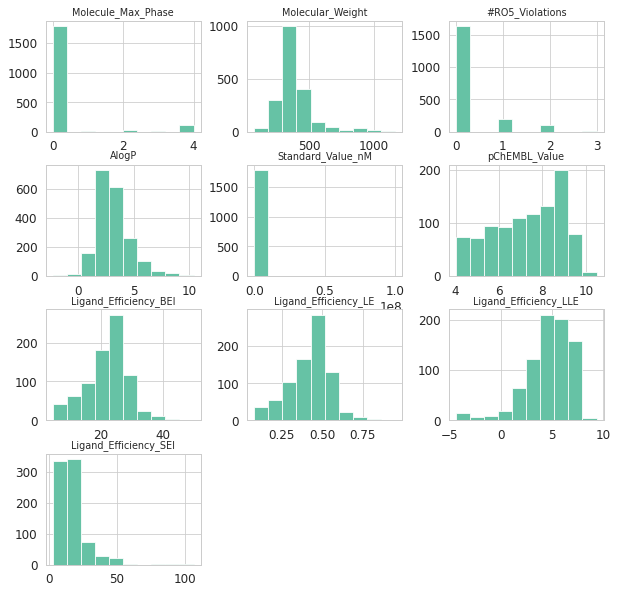

In [29]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types/assays represented in the value columns. Let's split those up:**

Standard_Type      % Ctrl  \
count            7.000000   
mean           109.714286   
std             15.283044   
min             94.000000   
25%             99.000000   
50%            101.000000   
75%            120.500000   
max            134.000000   

Standard_Type  % Inhibition of Control Specific Binding (Mean n=2)  \
count                                                   8.000000     
mean                                                   -3.700000     
std                                                     4.452287     
min                                                   -10.700000     
25%                                                    -6.350000     
50%                                                    -4.350000     
75%                                                     0.350000     
max                                                     2.000000     

Standard_Type      Activity          EC50   Efficacy       Emax  \
count             41.000000     24.000000   4.000000   2.000000   
mean             260.273171   7554.570706  25.225000  54.500000   
std             1559.327343  13061.147535  28.866402  55.861436   
min              -12.900000      1.100000  -0.100000  15.000000   
25%               -0.500000    178.000000   5.225000  34.750000   
50%                2.000000    214.222222  18.500000  54.500000   
75%               30.000000  10000.000000  38.500000  74.250000   
max            10000.000000  50118.720000  64.000000  94.000000   

Standard_Type           IC50  Inhibition            Ka   Kb            Kd  \
count             498.000000  418.000000     23.000000  1.0      4.000000   
mean            10069.385426   28.305755   7869.565217  0.3   3270.980750   
std             27059.164344   26.899361   2937.289224  NaN   6486.129538   
min                 0.090000  -18.890000   2200.000000  0.3      0.416000   
25%                 1.720000    4.062500   5350.000000  0.3      0.484250   
50%                80.350000   25.150000  10000.000000  0.3     41.753500   
75%              5451.162500   50.000000  10000.000000  0.3   3312.250000   
max            257039.580000  100.000000  10000.000000  0.3  13000.000000   

Standard_Type            Ki        Vmax  
count          5.020000e+02   25.000000  
mean           2.076276e+05   94.480000  
std            4.463049e+06   17.535084  
min            0.000000e+00   34.500000  
25%            7.300000e+00   96.000000  
50%            1.654800e+02  100.200000  
75%            4.934302e+03  104.000000  
max            1.000000e+08  107.900000

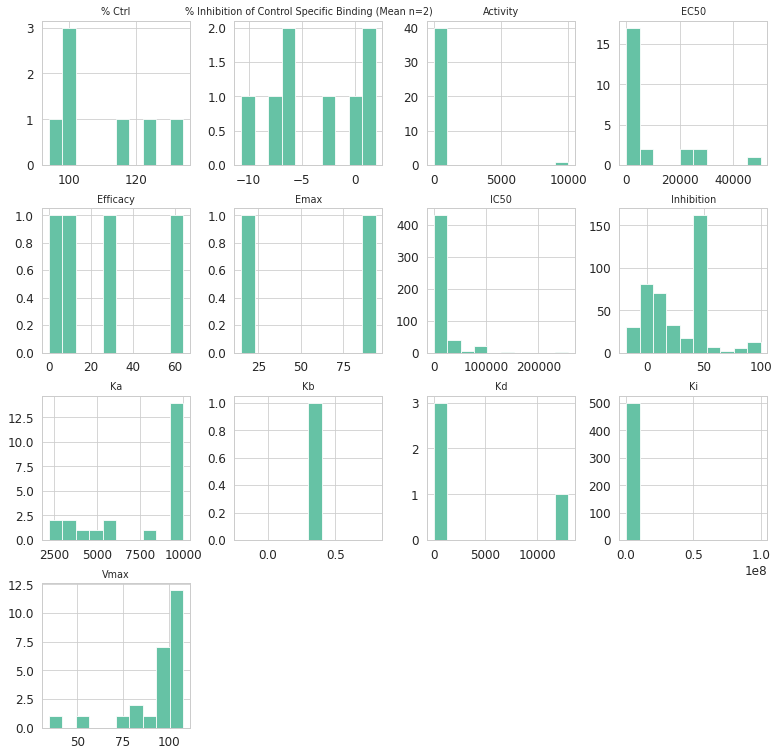

In [30]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13));

 What do you notice about the standard values?

Standard_Type       EC50        IC50        Kd          Ki
count          19.000000  408.000000  4.000000  405.000000
mean            6.684474    7.357423  7.681750    7.178580
std             1.152117    1.676965  2.153942    1.435567
min             4.580000    4.000000  4.890000    4.000000
25%             6.120000    5.792500  6.532500    6.150000
50%             6.750000    7.755000  8.205500    7.285000
75%             7.210000    8.900000  9.354750    8.330000
max             8.960000   10.050000  9.426000   10.500000

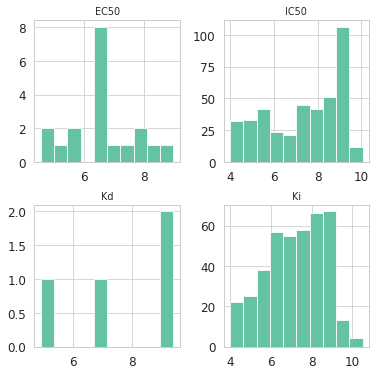

In [31]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the pChEMBL values?**

## DTC: Curation Step
- Add pValue column from raw measurements if it doesn't exist

In [32]:
dtc.iloc[0:3, 0:5]

Compound_ID Uniprot_ID Compound_Name           Standard_inchi_key  \
0   CHEMBL100086     P46098           NaN  OSVMSQACZRYAPT-UHFFFAOYSA-N   
1   CHEMBL104700     P46098           NaN  SCDKHPSUXHBJDJ-UHFFFAOYSA-N   
2  CHEMBL1079079     P46098           NaN  WGIPGQAPFNVWIX-XXFZXMJFSA-N   

   Max_Phase  
0          0  
1          0  
2          0

## DTC EDA

In [33]:
dtc=dtc.replace('None', np.nan)


In [34]:
dtc.head(3)

Compound_ID Uniprot_ID Compound_Name           Standard_inchi_key  \
0   CHEMBL100086     P46098           NaN  OSVMSQACZRYAPT-UHFFFAOYSA-N   
1   CHEMBL104700     P46098           NaN  SCDKHPSUXHBJDJ-UHFFFAOYSA-N   
2  CHEMBL1079079     P46098           NaN  WGIPGQAPFNVWIX-XXFZXMJFSA-N   

   Max_Phase                Target_Pref_Name Gene_Names Target_Class  \
0          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
1          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
2          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   

   Wild_type_or_mutant  Mutation_information   PubMed_ID  \
0                  NaN                   NaN  12482441.0   
1                  NaN                   NaN  22607684.0   
2                  NaN                   NaN  19767206.0   

  End_Point_Standard_Type End_Point_Standard_Relation  \
0                    IC50                           >   
1                      KI                         NaN   
2              INHIBITION                           <   

   End_Point_Standard_Value End_Point_Standard_Units  Endpoint_Mode_of_Action  \
0                  100000.0                       NM                      NaN   
1                       NaN                      NaN                      NaN   
2                      50.0                        %                      NaN   

  Assay_Format  Assay_Type  Assay_Sub_Type  Inhibitor_Type  \
0          NaN         NaN             NaN             NaN   
1          NaN         NaN             NaN             NaN   
2          NaN         NaN             NaN             NaN   

   Detection_Technology  Compound_concentration_value  \
0                   NaN                           NaN   
1                   NaN                           NaN   
2                   NaN                           NaN   

   Compound_concentration_value_units  Substrate_type  \
0                                 NaN             NaN   
1                                 NaN             NaN   
2                                 NaN             NaN   

   Substrate_Type_Standard_Relation  Substrate_Type_Standard_Value  \
0                               NaN                            NaN   
1                               NaN                            NaN   
2                               NaN                            NaN   

   Substrate_Type_Standard_Units Assay_cell_line  \
0                            NaN             NaN   
1                            NaN             NaN   
2                            NaN             NaN   

                                   Assay_Description Activity_Comments  \
0  Inhibitory concentration required against 5-HT...               NaN   
1                       Inhibition of 5-HT3 receptor    Not Determined   
2  Displacement of [3H]LY278584 from 5HT3 (recept...               NaN   

                                               Title  \
0    Development of a presynaptic 5-HT1A antagonist.   
1  7-Azabicyclo[2.2.1]heptane as a scaffold for t...   
2  Synthesis and in vitro autoradiographic evalua...   

                    Journal    Year  Volume  Issue  \
0  Bioorg. Med. Chem. Lett.  2003.0    13.0    2.0   
1  Bioorg. Med. Chem. Lett.  2012.0    22.0   12.0   
2  Bioorg. Med. Chem. Lett.  2009.0    19.0   21.0   

                                             Authors  Annotation_Comments  \
0  Mattson RJ, Catt JD, Sloan CP, Gao Q, Carter R...                  NaN   
1                 Banister SD, Rendina LM, Kassiou M                  NaN   
2  Donohue SR, Varnäs K, Jia Z, Gulyás B, Pike VW...                  NaN   

   Assay_ID      DTC_Tid  DTC_Activity_ID  DTC_Molregno  Record_ID  \
0    3062.0  DTCT0023221          1489397  DTCC00263953     917398   
1  820298.0  DTCT0023221         10478126  DTCC00272114     931177   
2  619795.0  DTCT0023221          3267809  DTCC00632772     857661   

   DTC_Document_ID  
0             5847  
1            48255  
2            37697

In [35]:
dtc.End_Point_Standard_Units.unique() #already all nM

array(['NM', nan, '%'], dtype=object)

In [36]:
dtc.End_Point_Standard_Type.unique()

array(['IC50', 'KI', 'INHIBITION', 'ACTIVITY', 'EC50', 'KD', 'EMAX',
       'PKI', 'KB', 'VMAX', 'EFFICACY', 'PIC50', 'SELECTIVITY RATIO'],
      dtype=object)

In [37]:
dtc[dtc.End_Point_Standard_Units=='NM'].End_Point_Standard_Type.unique()

array(['IC50', 'KI', 'EC50', 'KD', 'ACTIVITY', 'KB'], dtype=object)

Curation step: create pValues from normal values

In [38]:
# add pX column
dtc['pDTC_Value'] = np.where(dtc.End_Point_Standard_Units == 'NM',
                             -np.log10(dtc.End_Point_Standard_Value/1000000000 ),
                             dtc.End_Point_Standard_Value)

In [39]:
dtc.describe()

Max_Phase  Wild_type_or_mutant  Mutation_information     PubMed_ID  \
count  1310.000000                  0.0                   0.0  1.221000e+03   
mean      0.273282                  NaN                   NaN  2.021775e+07   
std       0.959917                  NaN                   NaN  4.378655e+06   
min       0.000000                  NaN                   NaN  1.652026e+06   
25%       0.000000                  NaN                   NaN  1.920847e+07   
50%       0.000000                  NaN                   NaN  2.114699e+07   
75%       0.000000                  NaN                   NaN  2.295924e+07   
max       4.000000                  NaN                   NaN  2.813524e+07   

       End_Point_Standard_Value  Endpoint_Mode_of_Action  Assay_Type  \
count              1.184000e+03                      0.0         0.0   
mean               9.446193e+04                      NaN         NaN   
std                2.906114e+06                      NaN         NaN   
min               -1.700000e+01                      NaN         NaN   
25%                1.336750e+01                      NaN         NaN   
50%                7.580000e+01                      NaN         NaN   
75%                3.750000e+03                      NaN         NaN   
max                1.000000e+08                      NaN         NaN   

       Assay_Sub_Type  Inhibitor_Type  Detection_Technology  \
count             0.0             0.0                   0.0   
mean              NaN             NaN                   NaN   
std               NaN             NaN                   NaN   
min               NaN             NaN                   NaN   
25%               NaN             NaN                   NaN   
50%               NaN             NaN                   NaN   
75%               NaN             NaN                   NaN   
max               NaN             NaN                   NaN   

       Compound_concentration_value  Compound_concentration_value_units  \
count                           0.0                                 0.0   
mean                            NaN                                 NaN   
std                             NaN                                 NaN   
min                             NaN                                 NaN   
25%                             NaN                                 NaN   
50%                             NaN                                 NaN   
75%                             NaN                                 NaN   
max                             NaN                                 NaN   

       Substrate_type  Substrate_Type_Standard_Relation  \
count             0.0                               0.0   
mean              NaN                               NaN   
std               NaN                               NaN   
min               NaN                               NaN   
25%               NaN                               NaN   
50%               NaN                               NaN   
75%               NaN                               NaN   
max               NaN                               NaN   

       Substrate_Type_Standard_Value  Substrate_Type_Standard_Units  \
count                            0.0                            0.0   
mean                             NaN                            NaN   
std                              NaN                            NaN   
min                              NaN                            NaN   
25%                              NaN                            NaN   
50%                              NaN                            NaN   
75%                              NaN                            NaN   
max                              NaN                            NaN   

              Year       Volume        Issue  Annotation_Comments  \
count  1191.000000  1129.000000  1099.000000                  0.0   
mean   2010.376154    40.450841    64.520473                  NaN   
std       3.739353    38.

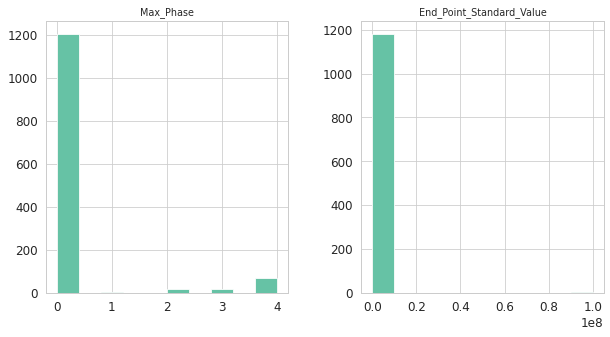

In [40]:
numeric_cols=['Max_Phase', 'End_Point_Standard_Value']
dtc[numeric_cols].hist(figsize=(10,5));

End_Point_Standard_Type      ACTIVITY          EC50   EFFICACY  EMAX  \
count                       26.000000     19.000000   4.000000   1.0   
mean                       411.119231   4869.599605  25.225000  15.0   
std                       1955.960159  12577.519415  28.866402   NaN   
min                         -7.000000      1.100000  -0.100000  15.0   
25%                         -0.250000    101.000000   5.225000  15.0   
50%                         28.000000    178.000000  18.500000  15.0   
75%                         50.000000   1210.000000  38.500000  15.0   
max                      10000.000000  50118.720000  64.000000  15.0   

End_Point_Standard_Type           IC50  INHIBITION   KB            KD  \
count                       194.000000  232.000000  1.0      4.000000   
mean                      18830.922569   34.748922  0.3   3270.962500   
std                       34557.858497   26.254918  NaN   6486.141808   
min                           0.090000  -17.000000  0.3      0.320000   
25%                         100.000000   10.300000  0.3      0.477500   
50%                        2602.972500   50.000000  0.3     41.765000   
75%                       30000.000000   50.000000  0.3   3312.250000   
max                      251188.640000  100.000000  0.3  13000.000000   

End_Point_Standard_Type            KI        VMAX  
count                    4.900000e+02   25.000000  
mean                     2.126429e+05   94.480000  
std                      4.517362e+06   17.535084  
min                      3.160000e-02   34.500000  
25%                      7.522500e+00   96.000000  
50%                      1.945000e+02  100.200000  
75%                      4.421250e+03  104.000000  
max                      1.000000e+08  107.900000

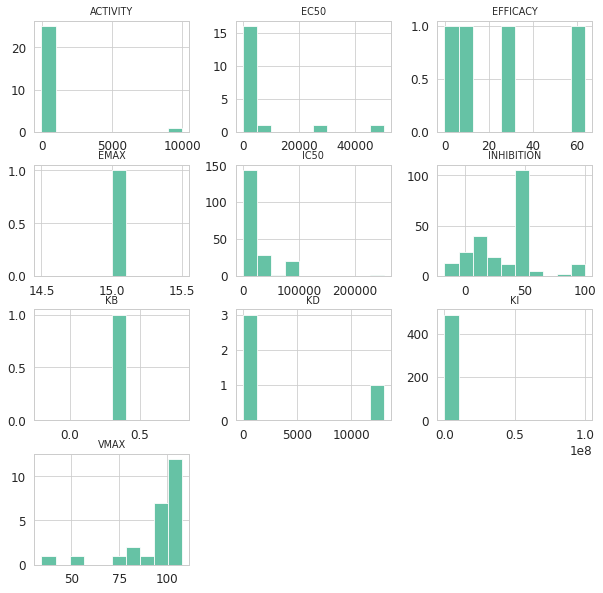

In [41]:
dtc_types=dtc.pivot_table(index = 'Compound_ID', columns = 'End_Point_Standard_Type', values='End_Point_Standard_Value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(10,10));

End_Point_Standard_Type   ACTIVITY       EC50   EFFICACY  EMAX        IC50  \
count                    26.000000  19.000000   4.000000   1.0  194.000000   
mean                     26.696154   6.630151  25.225000  15.0    5.787025   
std                      28.630997   1.211224  28.866402   NaN    1.295001   
min                      -7.000000   4.300000  -0.100000  15.0    3.600000   
25%                      -0.250000   6.086315   5.225000  15.0    4.522879   
50%                      23.500000   6.749580  18.500000  15.0    5.601545   
75%                      50.000000   7.184684  38.500000  15.0    7.000000   
max                      87.000000   8.958607  64.000000  15.0   10.045757   

End_Point_Standard_Type  INHIBITION        KB        KD          KI  \
count                    232.000000  1.000000  4.000000  490.000000   
mean                      34.748922  9.522879  7.684388    6.788864   
std                       26.254918       NaN  2.160629    1.555564   
min                      -17.000000  9.522879  4.886057    1.000000   
25%                       10.300000  9.522879  6.532206    5.402234   
50%                       50.000000  9.522879  8.178323    6.811128   
75%                       50.000000  9.522879  9.330506    8.136677   
max                      100.000000  9.522879  9.494850   10.500313   

End_Point_Standard_Type        VMAX  
count                     25.000000  
mean                      94.480000  
std                       17.535084  
min                       34.500000  
25%                       96.000000  
50%                      100.200000  
75%                      104.000000  
max                      107.900000

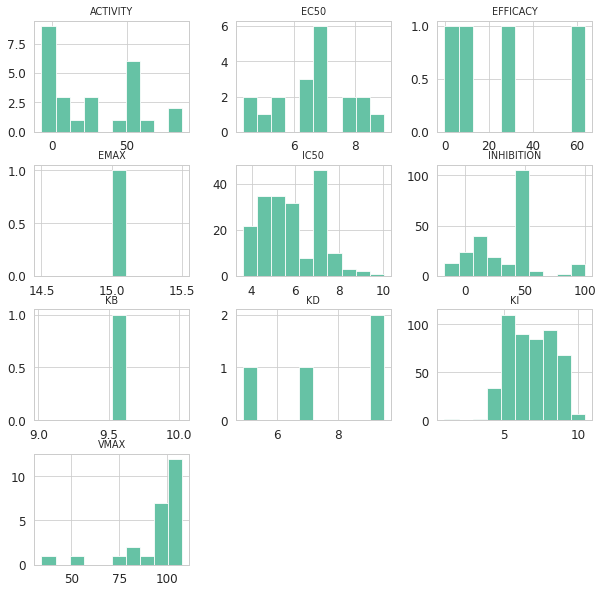

In [42]:
dtc_types=dtc.pivot_table(index = 'Compound_ID', columns = 'End_Point_Standard_Type', values='pDTC_Value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(10,10));

In [43]:
excape=excape.replace('None', np.nan)
excape.head()

Ambit_InchiKey Original_Entry_ID  Entrez_ID Activity_Flag  \
0  AZGOVLGMSGAOMP-FZYUQVBKNA-N      CHEMBL404232       3359             A   
1  BAZZAIKMNMNZJS-PKRZOPRNNA-N      CHEMBL494999      79246             A   
2  ARXTZNGJWWBBMH-LQFNOIFHNA-N          44157937      79246             A   
3  ASQVLAWCAVGHRV-UHFFFAOYNA-N      CHEMBL576046      79246             A   
4  ATBPRFXCCZLQCU-KHCWMJRFNA-N       CHEMBL40260       3359             A   

     pXC50        DB  Original_Assay_ID  Tax_ID Gene_Symbol  Ortholog_Group  \
0  5.52000  chembl20             989092    9606       HTR3A            2102   
1  7.36000  chembl20             523350   10116       HTR3A            2102   
2  8.52288   pubchem             375321   10116       HTR3A            2102   
3  7.65000  chembl20             592418   10116       HTR3A            2102   
4  8.48000  chembl20               3470    9606       HTR3A            2102   

                                              SMILES  
0        C=1C=C2C(/C=C/3\C(N(C(N3C)=N)C)=O)=CNC2=CC1  
1  N=1C=2C=CC=C(C)C2N3C(=CC=C3)C1N4CCN(CC4)C(C(=O...  
2   OC(=NO)CN1CCN(CC1)C2=NC=3C(N4C2=CC=C4)=C(C=CC3)C  
3  N1(C=NC=C1)CCN2CCN(C3=NC4=CC(=CC=C4N5C3=CC=C5)...  
4             C1(C=2N=C(CN=C(N)N)SC2)=CNC=3C1=CC=CC3

Entrez_ID       pXC50  Original_Assay_ID        Tax_ID  \
count    649.000000  645.000000       6.490000e+02    649.000000   
mean   16215.274268    6.983770       6.633640e+05   9715.318952   
std    27698.741204    1.505524       2.569910e+05    207.728422   
min     3359.000000    1.000000       3.123000e+03   9606.000000   
25%     3359.000000    5.800000       5.369680e+05   9606.000000   
50%     3359.000000    7.161150       6.525690e+05   9606.000000   
75%     3359.000000    8.140000       8.059070e+05   9606.000000   
max    79246.000000   10.500000       1.350972e+06  10116.000000   

       Ortholog_Group  
count           649.0  
mean           2102.0  
std               0.0  
min            2102.0  
25%            2102.0  
50%            2102.0  
75%            2102.0  
max            2102.0

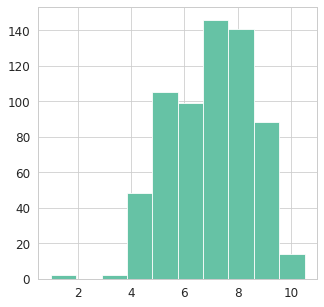

In [44]:
# excape only has one column we care about
display(excape.describe())
excape.pXC50.hist(figsize=(5,5));

# Compare pResponse values across ChEMBL, DTC and Excape-DB
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

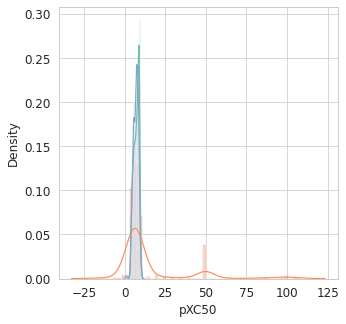

In [45]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(chembl.pChEMBL_Value, ax=ax)
sns.distplot(dtc.pDTC_Value, ax=ax)
sns.distplot(excape.pXC50, ax=ax);

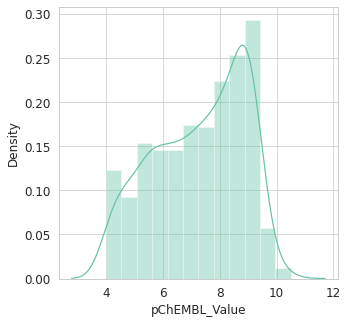

In [46]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(chembl.pChEMBL_Value, ax=ax)

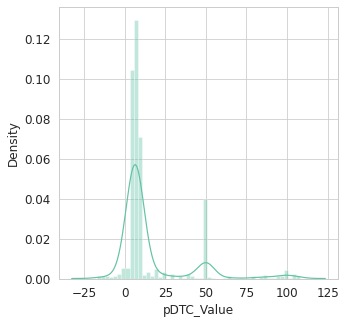

In [47]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(dtc.pDTC_Value, ax=ax)

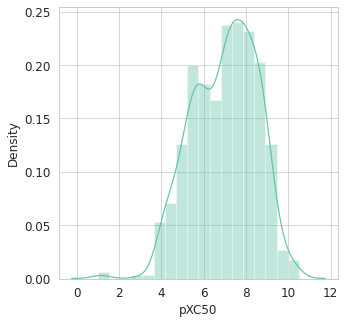

In [48]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
sns.distplot(excape.pXC50, ax=ax);

# Analysis
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

<p> I would model either pXC50 or pKI values. They are the most abundant in the dataset and commonly used for modeling. pKI is more normally distributed, but pXC50 values allow inclusion of excape data. 

According to some sources, these two datapoints can be combined in various ways, as well, but that's beyond the scope of this class.

I would choose a reasonable IC50 concentration to use as a threshold (perhaps 10uM, or consult with a scientist), and anything with an IC50 above that threshold is inactive (you need more drug to get activity) and IC50s below this threshold is active (you need less drug for activity, meaning the compound is MORE active per unit)

## EDA tips
- Make sure smiles strings exist since that's what AMPL uses
- Compare compounds in each dataset
- Featurize with ECFP fingerprints
- Examine diversity of compound set

# **Final Curation**

Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets/excel or from the LHS folder menu, right-click on the "HTR3A_DTC.csv" file to download it to your computer and open the file with Excel. 
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi  (use highlight and click on "Follow-link" option to open the link in your browser)
  - did you get the whole column??
  - Be sure to select the correct registry ID for the input id list
  - Select "Same CID" and SMILES as output

6. upload resulting text files into **AMPL_EDA_07** folder

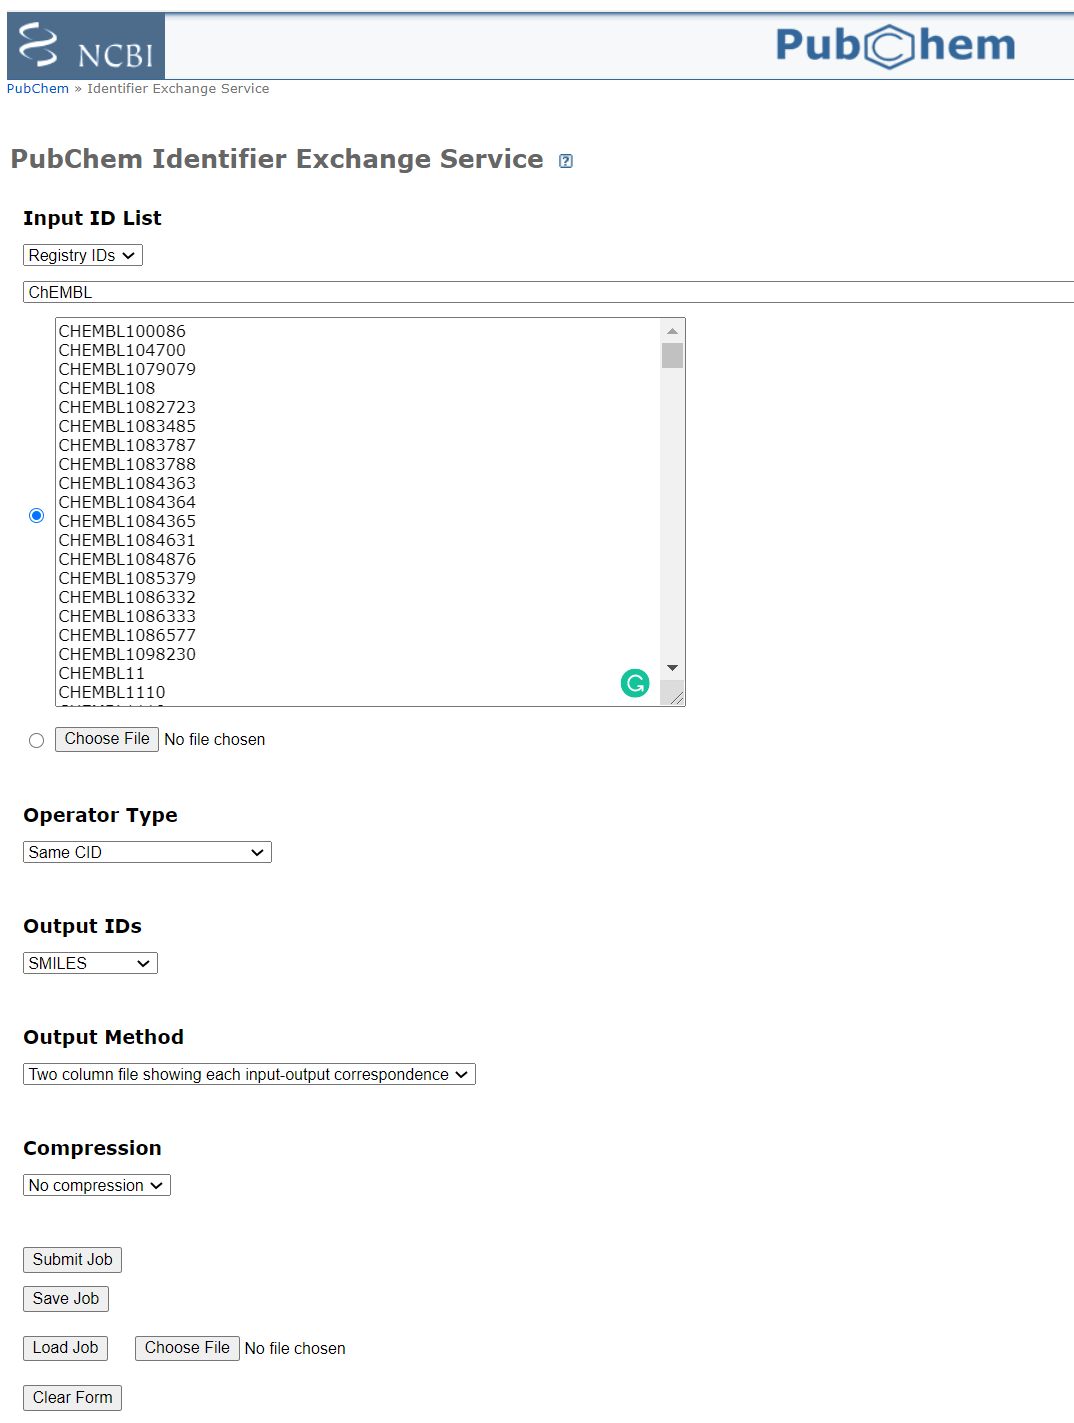

In [49]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/Img/PubChemCIDExchange.png", 
      width = 900, height = 900)

Note, the output from PubChem Identifier Exchange Service can be uploaded into the left hand window of COLAB by dragging and dropping the file. In my case the output file is, `3983437898785642818.txt`

In my case, I have saved the file in GitHub and I am loading it in the following code chunk 

In [50]:
# the file is also available from my Github link 
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/3983437898785642818.txt 
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/12345.txt

--2021-08-10 18:11:59--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/3983437898785642818.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90865 (89K) [text/plain]
Saving to: ‘3983437898785642818.txt’

3983437898785642818 100%[===================>]  88.74K  --.-KB/s    in 0.009s  

2021-08-10 18:11:59 (9.27 MB/s) - ‘3983437898785642818.txt’ saved [90865/90865]

--2021-08-10 18:11:59--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/12345.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

In [51]:
# uncomment if you want to acess the files 
dtc_smiles = pd.read_csv("3983437898785642818.txt", sep='\t', header=None)
dtc_smiles.head(3)

0                                                  1
0   CHEMBL100086  COC1=CC=CC(=C1)CN2CCN(CC2)C3CCC(CC3)(C4=CC5=C(...
1   CHEMBL104700                            C1CC2CCC1N2CC3=CN=CC=C3
2  CHEMBL1079079  COC1=CC=C(C=C1)C2=C(C(=NN2C3=CC=CC=C3[125I])C(...

In [52]:
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

ChEMBL_ID                                             SMILES
0   CHEMBL100086  COC1=CC=CC(=C1)CN2CCN(CC2)C3CCC(CC3)(C4=CC5=C(...
1   CHEMBL104700                            C1CC2CCC1N2CC3=CN=CC=C3
2  CHEMBL1079079  COC1=CC=C(C=C1)C2=C(C(=NN2C3=CC=CC=C3[125I])C(...
3      CHEMBL108               C1=CC=C2C(=C1)C=CC3=CC=CC=C3N2C(=O)N
4  CHEMBL1082723  C[C@H]1CC2=C([C@]3(N1)C4=C(C=CC(=C4)Cl)NC3=O)N...

In [53]:
dtc[['Compound_ID']].head(3)

Compound_ID
0   CHEMBL100086
1   CHEMBL104700
2  CHEMBL1079079

#### Let us explore the `map(dict(zip()))` construct

In [54]:
# map chembl id to smiles using a dict
dtc['SMILES'] = dtc['Compound_ID'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [55]:
# what's missing?
print("No ChemblID in DTC:", len(dtc[dtc['Compound_ID'].isna()]))
print("No SMILES from ChemblID in DTC:", len(dtc[dtc.SMILES.isna()]))

No ChemblID in DTC: 29
No SMILES from ChemblID in DTC: 33


No SMILES for 4 compounds that had ChEMBL IDs. They are 

      Compound_ID	 Standard_inchi_key        	               SMILES
767	CHEMBL3085543	 BXTUHNWXQLWICJ-DIXMSKSGSA-L	
768	CHEMBL3085543	 BXTUHNWXQLWICJ-DIXMSKSGSA-L	
769	CHEMBL3085543	 BXTUHNWXQLWICJ-DIXMSKSGSA-L	
770	CHEMBL3085543	 BXTUHNWXQLWICJ-DIXMSKSGSA-L


Another 29 of them had no ChEMBL IDs 

         Compound_ID	Standard_inchi_key        	SMILES
1281		              ABZSPJVXTTUFAA-UHFFFAOYSA-N	
1282		              ABZSPJVXTTUFAA-UHFFFAOYSA-N	
1283		              ABZSPJVXTTUFAA-UHFFFAOYSA-N	
1284		VBOQYPQEPHKASR-GSVOUGTGSA-N	
1285		PDNJLMZEGXHSCU-GSVOUGTGSA-N	
1286		KIWQWJKWBHZMDT-GSVOUGTGSA-N	
1287		VBOQYPQEPHKASR-UHFFFAOYSA-N	
1288		DYIRSNMPIZZNBK-UHFFFAOYSA-N	
1289		HXTGXYRHXAGCFP-UHFFFAOYSA-N	
1290		WPEBMRNXFWCMHU-UHFFFAOYSA-N	
1291		ZITSATWAZDKOBF-UHFFFAOYSA-N	
1292		KRBFLOBPUMORJO-UHFFFAOYSA-N	
1293		IDRHDKGNUNKODU-UHFFFAOYSA-N	
1294		IVHTZIIPDCREHO-UHFFFAOYSA-N	
1295		WPPPKVSENOHDIG-UHFFFAOYSA-N	
1296		BWGIECJEQVGDRP-UHFFFAOYSA-N	
1297		PKNNCDGLZOSLJS-UHFFFAOYSA-N	
1298		SUGVYNSRNKFXQM-ACSDJOOWSA-N	
1299		QLOOWOVVZLBYHU-UHFFFAOYSA-N	
1300		YPAKIZUIDJVWEU-UHFFFAOYSA-N	
1301		IULBXDZWXBXGNP-UHFFFAOYSA-N	
1302		JBGBKQZMARTYMJ-UHFFFAOYSA-N	
1303		OIOMPFBFUIBOFU-UHFFFAOYSA-N	
1304		YQZJKNSLWYSIQK-UHFFFAOYSA-N	
1305		GKQNHLVTVYRVPU-UHFFFAOYSA-N	
1306		FHGYGOURWHLFKB-UHFFFAOYSA-N	
1307		BYOFGWKOPRCCDL-UHFFFAOYSA-N	
1308		BKOSOHWFMPLYRS-UHFFFAOYSA-N	
1309		HOASDGCNODVMOU-UHFFFAOYSA-N	

In [56]:
# if you want to explore the data outside of COLAB
#  dtc.to_csv("test.csv")

#### For the missing Compound IDs, let us try to recover the SMILES from InChi Keys

In [57]:
dtc[dtc.SMILES.isna()]['Standard_inchi_key'].unique().tolist()

['BXTUHNWXQLWICJ-DIXMSKSGSA-L',
 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
 'VBOQYPQEPHKASR-GSVOUGTGSA-N',
 'PDNJLMZEGXHSCU-GSVOUGTGSA-N',
 'KIWQWJKWBHZMDT-GSVOUGTGSA-N',
 'VBOQYPQEPHKASR-UHFFFAOYSA-N',
 'DYIRSNMPIZZNBK-UHFFFAOYSA-N',
 'HXTGXYRHXAGCFP-UHFFFAOYSA-N',
 'WPEBMRNXFWCMHU-UHFFFAOYSA-N',
 'ZITSATWAZDKOBF-UHFFFAOYSA-N',
 'KRBFLOBPUMORJO-UHFFFAOYSA-N',
 'IDRHDKGNUNKODU-UHFFFAOYSA-N',
 'IVHTZIIPDCREHO-UHFFFAOYSA-N',
 'WPPPKVSENOHDIG-UHFFFAOYSA-N',
 'BWGIECJEQVGDRP-UHFFFAOYSA-N',
 'PKNNCDGLZOSLJS-UHFFFAOYSA-N',
 'SUGVYNSRNKFXQM-ACSDJOOWSA-N',
 'QLOOWOVVZLBYHU-UHFFFAOYSA-N',
 'YPAKIZUIDJVWEU-UHFFFAOYSA-N',
 'IULBXDZWXBXGNP-UHFFFAOYSA-N',
 'JBGBKQZMARTYMJ-UHFFFAOYSA-N',
 'OIOMPFBFUIBOFU-UHFFFAOYSA-N',
 'YQZJKNSLWYSIQK-UHFFFAOYSA-N',
 'GKQNHLVTVYRVPU-UHFFFAOYSA-N',
 'FHGYGOURWHLFKB-UHFFFAOYSA-N',
 'BYOFGWKOPRCCDL-UHFFFAOYSA-N',
 'BKOSOHWFMPLYRS-UHFFFAOYSA-N',
 'HOASDGCNODVMOU-UHFFFAOYSA-N']

The file 12345.txt is the output from NCBI ID Exchange using the above 29 InChi keys as input

In [58]:
dtc.head(2)

Compound_ID Uniprot_ID Compound_Name           Standard_inchi_key  \
0  CHEMBL100086     P46098           NaN  OSVMSQACZRYAPT-UHFFFAOYSA-N   
1  CHEMBL104700     P46098           NaN  SCDKHPSUXHBJDJ-UHFFFAOYSA-N   

   Max_Phase                Target_Pref_Name Gene_Names Target_Class  \
0          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
1          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   

   Wild_type_or_mutant  Mutation_information   PubMed_ID  \
0                  NaN                   NaN  12482441.0   
1                  NaN                   NaN  22607684.0   

  End_Point_Standard_Type End_Point_Standard_Relation  \
0                    IC50                           >   
1                      KI                         NaN   

   End_Point_Standard_Value End_Point_Standard_Units  Endpoint_Mode_of_Action  \
0                  100000.0                       NM                      NaN   
1                       NaN                      NaN                      NaN   

  Assay_Format  Assay_Type  Assay_Sub_Type  Inhibitor_Type  \
0          NaN         NaN             NaN             NaN   
1          NaN         NaN             NaN             NaN   

   Detection_Technology  Compound_concentration_value  \
0                   NaN                           NaN   
1                   NaN                           NaN   

   Compound_concentration_value_units  Substrate_type  \
0                                 NaN             NaN   
1                                 NaN             NaN   

   Substrate_Type_Standard_Relation  Substrate_Type_Standard_Value  \
0                               NaN                            NaN   
1                               NaN                            NaN   

   Substrate_Type_Standard_Units Assay_cell_line  \
0                            NaN             NaN   
1                            NaN             NaN   

                                   Assay_Description Activity_Comments  \
0  Inhibitory concentration required against 5-HT...               NaN   
1                       Inhibition of 5-HT3 receptor    Not Determined   

                                               Title  \
0    Development of a presynaptic 5-HT1A antagonist.   
1  7-Azabicyclo[2.2.1]heptane as a scaffold for t...   

                    Journal    Year  Volume  Issue  \
0  Bioorg. Med. Chem. Lett.  2003.0    13.0    2.0   
1  Bioorg. Med. Chem. Lett.  2012.0    22.0   12.0   

                                             Authors  Annotation_Comments  \
0  Mattson RJ, Catt JD, Sloan CP, Gao Q, Carter R...                  NaN   
1                 Banister SD, Rendina LM, Kassiou M                  NaN   

   Assay_ID      DTC_Tid  DTC_Activity_ID  DTC_Molregno  Record_ID  \
0    3062.0  DTCT0023221          1489397  DTCC00263953     917398   
1  820298.0  DTCT0023221         10478126  DTCC00272114     931177   

   DTC_Document_ID  pDTC_Value  \
0             5847         4.0   
1            48255         NaN   

                                              SMILES  
0  COC1=CC=CC(=C1)CN2CCN(CC2)C3CCC(CC3)(C4=CC5=C(...  
1                            C1CC2CCC1N2CC3=CN=CC=C3

In [59]:
# if you havent completed the conversion, you can access the file from my GitHub link
inchi_smiles = pd.read_csv("12345.txt", sep='\t', header=None)
inchi_smiles.head(3)

0  \
0  BXTUHNWXQLWICJ-DIXMSKSGSA-L   
1  ABZSPJVXTTUFAA-UHFFFAOYSA-N   
2  VBOQYPQEPHKASR-GSVOUGTGSA-N   

                                                   1  
0                                                NaN  
1  CC(=O)NC1=CC=C(C=C1)C(=O)NC2=C(C=CC(=C2)C3=CC=...  
2                       C(CS(=O)(=O)O)[C@H](C(=O)O)N

In [60]:
inchi_smiles=inchi_smiles.rename(columns = {0:'INCHIKEY',1:'SMILES'})
inchi_smiles

INCHIKEY  \
0   BXTUHNWXQLWICJ-DIXMSKSGSA-L   
1   ABZSPJVXTTUFAA-UHFFFAOYSA-N   
2   VBOQYPQEPHKASR-GSVOUGTGSA-N   
3   PDNJLMZEGXHSCU-GSVOUGTGSA-N   
4   KIWQWJKWBHZMDT-GSVOUGTGSA-N   
..                          ...   
23  GKQNHLVTVYRVPU-UHFFFAOYSA-N   
24  FHGYGOURWHLFKB-UHFFFAOYSA-N   
25  BYOFGWKOPRCCDL-UHFFFAOYSA-N   
26  BKOSOHWFMPLYRS-UHFFFAOYSA-N   
27  HOASDGCNODVMOU-UHFFFAOYSA-N   

                                               SMILES  
0                                                 NaN  
1   CC(=O)NC1=CC=C(C=C1)C(=O)NC2=C(C=CC(=C2)C3=CC=...  
2                        C(CS(=O)(=O)O)[C@H](C(=O)O)N  
3                            C(CS(=O)O)[C@H](C(=O)O)N  
4                                   C1CSC(=O)[C@@H]1N  
..                                                ...  
23   CC1=NC2=C(C=C(S2)C3=CC=CC=C3)C(=N1)SCC4=CC=CC=C4  
24             CC(=O)CSC1=NC=NC2=C1C=C(S2)C3=CC=CC=C3  
25  C1=CC=C(C=C1)C2=CC3=C(N=CN=C3S2)OC4=CC=C(C=C4)C=O  
26                          CC1=C(SC2=NC=NC(=C12)NC)C  
27                             CC1=CC2=C(S1)N=CN=C2SC  

[28 rows x 2 columns]

In [61]:
dtc['SMILES'].isna().sum()
dtc['Standard_inchi_key'].isnull().sum()
dtc['SMILES'].isnull().sum()
dtc['SMILES'].head(3)

0    COC1=CC=CC(=C1)CN2CCN(CC2)C3CCC(CC3)(C4=CC5=C(...
1                              C1CC2CCC1N2CC3=CN=CC=C3
2    COC1=CC=C(C=C1)C2=C(C(=NN2C3=CC=CC=C3[125I])C(...
Name: SMILES, dtype: object

In [62]:
my_dict = dict(zip( inchi_smiles.INCHIKEY, inchi_smiles.SMILES))
dtc['SMILES1'] = dtc['Standard_inchi_key'].map(my_dict)

In [63]:
# checking

print(dtc['SMILES'].isna().sum())
print(chembl['Smiles'].isna().sum())
print(excape['SMILES'].isna().sum())


33
1
0


In [64]:
dtc['SMILES']= np.where(dtc['SMILES'].isnull(), dtc['SMILES1'], dtc['SMILES'])

In [65]:
dtc = dtc.drop(['SMILES1'], axis=1)

In [66]:
dtc=dtc.replace('None', np.nan)

# EDA: Examine compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

In [67]:
from matplotlib_venn import venn3
from matplotlib_venn import venn2

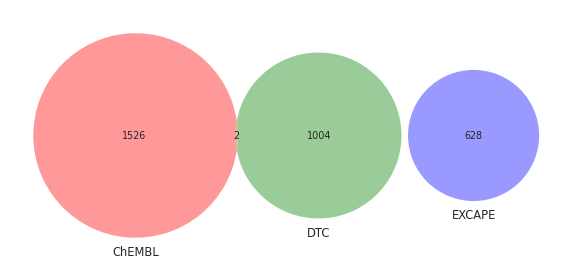

In [68]:
# overlaps from SMILES strings
venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

### venn diagram 

For overlapping ChEMBL IDs - mpv requires sets not lists

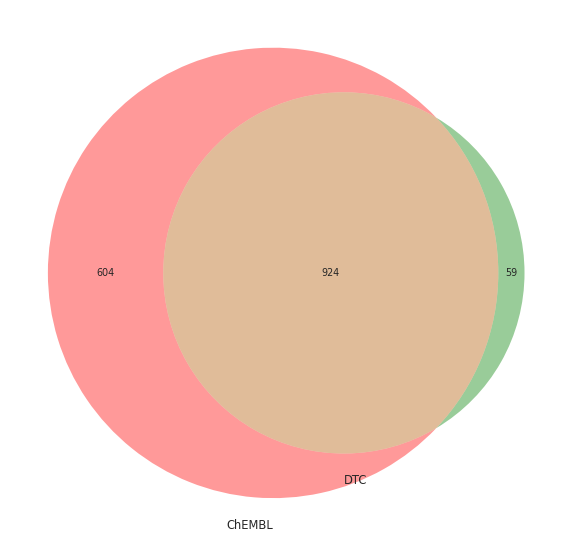

In [69]:
venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc.Compound_ID)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

# **Curation step:** Standardize smiles strings, drop rows without base smiles

In [70]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(curate_data.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

1950
1528
1528


In [71]:
chembl[chembl.base_rdkit_smiles=='']

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase  Molecular_Weight  \
1638      CHEMBL4532510           NaN                 0.0               NaN   

      #RO5_Violations  AlogP Compound_Key Smiles Standard_Type  \
1638              NaN    NaN          NaN    NaN    Inhibition   

     Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
1638               '='            4.05              %            NaN   

     Data_Validity_Comment     Comment    Uo_Units  Ligand_Efficiency_BEI  \
1638                   NaN  Not Active  UO_0000187                    NaN   

      Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
1638                   NaN                    NaN                    NaN   

      Potential_Duplicate Assay_ChEMBL_ID  \
1638                False   CHEMBL4507808   

                        Assay_Description Assay_Type BAO_Format_ID  \
1638  GPCRScan assay: inhibition of 5-HT3          B   BAO_0000357   

                  BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID  \
1638  single protein format   Homo sapiens                    NaN   

     Assay_Tissue_Name Assay_Cell_Type  Assay_Subcellular_Fraction  \
1638               NaN             NaN                         NaN   

                                       Assay_Parameters  \
1638  Parental cells: HEKT | PMID: 2164935/8436978 |...   

     Assay_Variant_Accession Assay_Variant_Mutation Target_ChEMBL_ID  \
1638                     NaN                    NaN       CHEMBL1899   

                         Target_Name Target_Organism     Target_Type  \
1638  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   

     Document_ChEMBL_ID  Source_ID                       Source_Description  \
1638      CHEMBL4507304         54  Donated Chemical Probes - SGC Frankfurt   

     Document_Journal  Document_Year Cell_ChEMBL_ID  \
1638              NaN            NaN            NaN   

                               Properties  Standard_Value_nM base_rdkit_smiles  
1638  Compound concentration None 10.0 uM               4.05

In [72]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase  Molecular_Weight  \
1638      CHEMBL4532510           NaN                 0.0               NaN   

      #RO5_Violations  AlogP Compound_Key Smiles Standard_Type  \
1638              NaN    NaN          NaN    NaN    Inhibition   

     Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
1638               '='            4.05              %            NaN   

     Data_Validity_Comment     Comment    Uo_Units  Ligand_Efficiency_BEI  \
1638                   NaN  Not Active  UO_0000187                    NaN   

      Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
1638                   NaN                    NaN                    NaN   

      Potential_Duplicate Assay_ChEMBL_ID  \
1638                False   CHEMBL4507808   

                        Assay_Description Assay_Type BAO_Format_ID  \
1638  GPCRScan assay: inhibition of 5-HT3          B   BAO_0000357   

                  BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID  \
1638  single protein format   Homo sapiens                    NaN   

     Assay_Tissue_Name Assay_Cell_Type  Assay_Subcellular_Fraction  \
1638               NaN             NaN                         NaN   

                                       Assay_Parameters  \
1638  Parental cells: HEKT | PMID: 2164935/8436978 |...   

     Assay_Variant_Accession Assay_Variant_Mutation Target_ChEMBL_ID  \
1638                     NaN                    NaN       CHEMBL1899   

                         Target_Name Target_Organism     Target_Type  \
1638  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   

     Document_ChEMBL_ID  Source_ID                       Source_Description  \
1638      CHEMBL4507304         54  Donated Chemical Probes - SGC Frankfurt   

     Document_Journal  Document_Year Cell_ChEMBL_ID  \
1638              NaN            NaN            NaN   

                               Properties  Standard_Value_nM base_rdkit_smiles  
1638  Compound concentration None 10.0 uM               4.05               NaN

In [73]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

In [74]:
chembl[chembl.base_rdkit_smiles=='']

Empty DataFrame
Columns: [Molecule_ChEMBL_ID, Molecule_Name, Molecule_Max_Phase, Molecular_Weight, #RO5_Violations, AlogP, Compound_Key, Smiles, Standard_Type, Standard_Relation, Standard_Value, Standard_Units, pChEMBL_Value, Data_Validity_Comment, Comment, Uo_Units, Ligand_Efficiency_BEI, Ligand_Efficiency_LE, Ligand_Efficiency_LLE, Ligand_Efficiency_SEI, Potential_Duplicate, Assay_ChEMBL_ID, Assay_Description, Assay_Type, BAO_Format_ID, BAO_Label, Assay_Organism, Assay_Tissue_ChEMBL_ID, Assay_Tissue_Name, Assay_Cell_Type, Assay_Subcellular_Fraction, Assay_Parameters, Assay_Variant_Accession, Assay_Variant_Mutation, Target_ChEMBL_ID, Target_Name, Target_Organism, Target_Type, Document_ChEMBL_ID, Source_ID, Source_Description, Document_Journal, Document_Year, Cell_ChEMBL_ID, Properties, Standard_Value_nM, base_rdkit_smiles]
Index: []

## Standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [75]:
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(curate_data.base_smiles_from_smiles)
dtc=dtc.replace('',np.nan)
dtc[dtc.base_rdkit_smiles.isna()]

Compound_ID Uniprot_ID Compound_Name           Standard_inchi_key  \
767   CHEMBL3085543     P46098           NaN  BXTUHNWXQLWICJ-DIXMSKSGSA-L   
768   CHEMBL3085543     P46098           NaN  BXTUHNWXQLWICJ-DIXMSKSGSA-L   
769   CHEMBL3085543     P46098           NaN  BXTUHNWXQLWICJ-DIXMSKSGSA-L   
770   CHEMBL3085543     P46098           NaN  BXTUHNWXQLWICJ-DIXMSKSGSA-L   
1294            NaN     P46098          PU07  IVHTZIIPDCREHO-UHFFFAOYSA-N   

      Max_Phase                Target_Pref_Name Gene_Names Target_Class  \
767           0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
768           0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
769           0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
770           0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   
1294          0  SEROTONIN 3A (5-HT3A) RECEPTOR      HTR3A  Ion channel   

      Wild_type_or_mutant  Mutation_information   PubMed_ID  \
767                   NaN                   NaN  17722904.0   
768                   NaN                   NaN  17722904.0   
769                   NaN                   NaN  17722904.0   
770                   NaN                   NaN  17722904.0   
1294                  NaN                   NaN  22589534.0   

     End_Point_Standard_Type End_Point_Standard_Relation  \
767                     IC50                           >   
768                     IC50                           >   
769                       KI                           >   
770                       KI                           >   
1294                    IC50                           =   

      End_Point_Standard_Value End_Point_Standard_Units  \
767                   100000.0                       NM   
768                   100000.0                       NM   
769                   100000.0                       NM   
770                   100000.0                       NM   
1294                  100000.0                       NM   

      Endpoint_Mode_of_Action Assay_Format  Assay_Type  Assay_Sub_Type  \
767                       NaN   cell_based         NaN             NaN   
768                       NaN   cell_based         NaN             NaN   
769                       NaN   cell_based         NaN             NaN   
770                       NaN   cell_based         NaN             NaN   
1294                      NaN          NaN         NaN             NaN   

      Inhibitor_Type  Detection_Technology  Compound_concentration_value  \
767              NaN                   NaN                           NaN   
768              NaN                   NaN                           NaN   
769              NaN                   NaN                           NaN   
770              NaN                   NaN                           NaN   
1294             NaN                   NaN                           NaN   

      Compound_concentration_value_units  Substrate_type  \
767                                  NaN             NaN   
768                                  NaN             NaN   
769                                  NaN             NaN   
770                                  NaN             NaN   
1294                                 NaN             NaN   

      Substrate_Type_Standard_Relation  Substrate_Type_Standard_Value  \
767                                NaN                            NaN   
768                                NaN                            NaN   
769                                NaN                            NaN   
770                                NaN                            NaN   
1294                               NaN                            NaN   

      Substrate_Type_Standard_Units Assay_cell_line  \
767                             NaN          HEK293   
768                             NaN          HEK293   
769                             NaN          HEK293   
770                             NaN          HEK293   
1294                  

In [76]:
dtc = dtc[~dtc.base_rdkit_smiles.isna()]

In [77]:
dtc[dtc.base_rdkit_smiles=='']

Empty DataFrame
Columns: [Compound_ID, Uniprot_ID, Compound_Name, Standard_inchi_key, Max_Phase, Target_Pref_Name, Gene_Names, Target_Class, Wild_type_or_mutant, Mutation_information, PubMed_ID, End_Point_Standard_Type, End_Point_Standard_Relation, End_Point_Standard_Value, End_Point_Standard_Units, Endpoint_Mode_of_Action, Assay_Format, Assay_Type, Assay_Sub_Type, Inhibitor_Type, Detection_Technology, Compound_concentration_value, Compound_concentration_value_units, Substrate_type, Substrate_Type_Standard_Relation, Substrate_Type_Standard_Value, Substrate_Type_Standard_Units, Assay_cell_line, Assay_Description, Activity_Comments, Title, Journal, Year, Volume, Issue, Authors, Annotation_Comments, Assay_ID, DTC_Tid, DTC_Activity_ID, DTC_Molregno, Record_ID, DTC_Document_ID, pDTC_Value, SMILES, base_rdkit_smiles]
Index: []

In [78]:
excape['base_rdkit_smiles'] = excape.SMILES.apply(curate_data.base_smiles_from_smiles)

In [79]:
excape = excape.replace('',np.nan)
excape[excape.base_rdkit_smiles.isna()]

Empty DataFrame
Columns: [Ambit_InchiKey, Original_Entry_ID, Entrez_ID, Activity_Flag, pXC50, DB, Original_Assay_ID, Tax_ID, Gene_Symbol, Ortholog_Group, SMILES, base_rdkit_smiles]
Index: []

In [80]:
dtc.iloc[:, [-1, -2]].head(3)

base_rdkit_smiles  \
0  COc1cccc(CN2CCN(C3CCC(O)(c4ccc5c(c4)OCO5)CC3)C...   
1                             c1cncc(CN2C3CCC2CC3)c1   
2  COc1ccc(-c2c(C#N)c(C(=O)NN3CCCCC3)nn2-c2ccccc2...   

                                              SMILES  
0  COC1=CC=CC(=C1)CN2CCN(CC2)C3CCC(CC3)(C4=CC5=C(...  
1                            C1CC2CCC1N2CC3=CN=CC=C3  
2  COC1=CC=C(C=C1)C2=C(C(=NN2C3=CC=CC=C3[125I])C(...

In [81]:
excape.iloc[:, [-1, -2]].head(3)

base_rdkit_smiles  \
0            CN1C(=N)N(C)/C(=C/c2c[nH]c3ccccc23)C1=O   
1  Cc1cccc2nc(N3CCN(C(C(=O)O)c4ccccc4)CC3)c3cccn3c12   
2           Cc1cccc2nc(N3CCN(CC(O)=NO)CC3)c3cccn3c12   

                                              SMILES  
0        C=1C=C2C(/C=C/3\C(N(C(N3C)=N)C)=O)=CNC2=CC1  
1  N=1C=2C=CC=C(C)C2N3C(=CC=C3)C1N4CCN(CC4)C(C(=O...  
2   OC(=NO)CN1CCN(CC1)C2=NC=3C(N4C2=CC=C4)=C(C=CC3)C

**Note the name `Smiles` compared to dtc and excape**

In [82]:
chembl[['base_rdkit_smiles','Smiles']].head(3)

base_rdkit_smiles  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...   
1                                           NCC(=O)O   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2   

                                              Smiles  
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...  
1                                           NCC(=O)O  
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2

# **Curation step:** Save standardized datasets

**If want to save the files for later use, mount your google drive and create a folder and save it there. Please note that in this step, you are about to create a folder called `AMPL_EDA_07` in Google Drive.**

In [83]:
%%bash 
mkdir -p /content/drive/MyDrive/AMPL_EDA_07

In [84]:
chembl.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_ChEMBL_SMILES_std.csv")
dtc.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_DTC_SMILES_std.csv")
excape.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_Excape_SMILES_std.csv")

## Examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

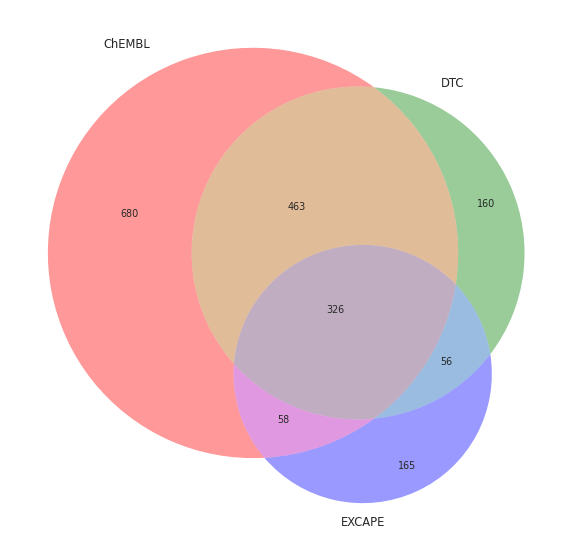

In [85]:
mpv.venn3([set(chembl.base_rdkit_smiles),
           set(dtc.base_rdkit_smiles),
           set(excape.base_rdkit_smiles)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

That's more like it. For even further overlaps, it's possible to pass all of them through the pubchem ID exchange: use input as smiles and output as smiles, then create base_rdkit_smiles again. You should see some increase in overlap with this pre-processing step.

# EDA: Examine compound diversity

 If you want to restart, you can start from here. Please uncomment the following code chunk 

In [86]:
# chembl=pd.read_csv("/content/drive/MyDrive/CE4511/HTR3A_ChEMBL_SMILES_std.csv", index_col=0)
# dtc=pd.read_csv("/content/drive/MyDrive/CE4511/HTR3A_DTC_SMILES_std.csv", index_col=0)
# excape=pd.read_csv("/content/drive/MyDrive/CE4511/HTR3A_Excape_SMILES_std.csv", index_col=0)

In [87]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat

import umap
from scipy.stats.kde import gaussian_kde
from scipy.cluster.hierarchy import linkage

ndist_max = 1000000

def plot_tani_dist_distr(dataset, smiles_col, dataset_name, **metric_kwargs):
    """
    Generate a density plot showing the distribution of distances between ecfp feature
    vectors, using the tanimoto metric.
    """
    # log = logging.getLogger('ATOM')
    num_cmpds = len(dataset)
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    # log.warning("Starting distance matrix calculation for %d compounds" % num_cmpds)
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    smiles_arr1 = dataset[smiles_col].values
    mols1 = [Chem.MolFromSmiles(s) for s in smiles_arr1]
    fprints1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in mols1]
    dists = GetTanimotoDistMat(fprints1)

    # log.warning("Finished calculation of %d distances" % len(dists))

    if len(dists) > ndist_max:
        # Sample a subset of the distances so KDE doesn't take so long
        dist_sample = np.random.choice(dists, size=ndist_max)
    else:
        dist_sample = dists

    dist_pdf = gaussian_kde(dist_sample)
    x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
    y_plt = dist_pdf(x_plt)
    fig, ax = plt.subplots(figsize=(8.0,8.0))
    ax.plot(x_plt, y_plt)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')
    ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
                  dataset_name, dist_metric, feat_type))
    return dists


In [88]:
sns.set_context('poster')

array([0.93548387, 0.86206897, 0.98076923, ..., 0.88235294, 0.84810127,
       0.9047619 ])

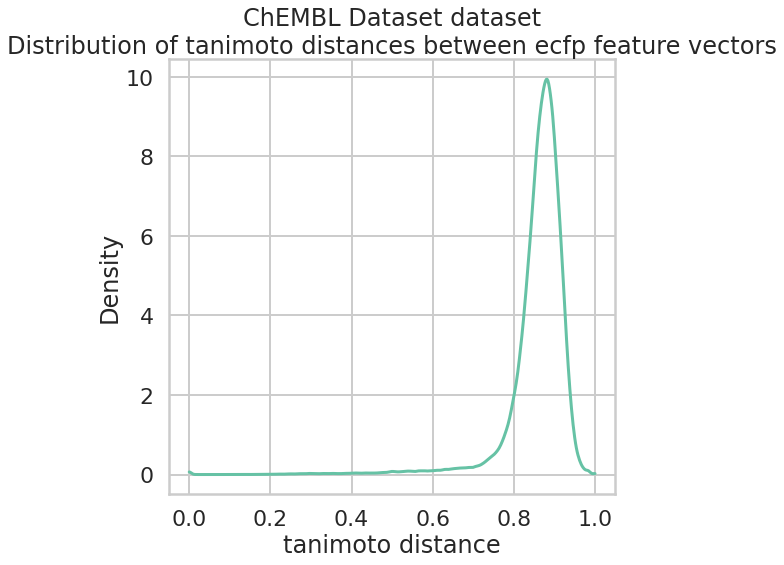

In [89]:
plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset')

In [90]:
chembl[['Molecule_ChEMBL_ID','base_rdkit_smiles','pChEMBL_Value']].head(3)

Molecule_ChEMBL_ID                                  base_rdkit_smiles  \
0      CHEMBL3233676  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...   
1          CHEMBL773                                           NCC(=O)O   
2      CHEMBL3261486    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2   

   pChEMBL_Value  
0            NaN  
1            NaN  
2            NaN

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


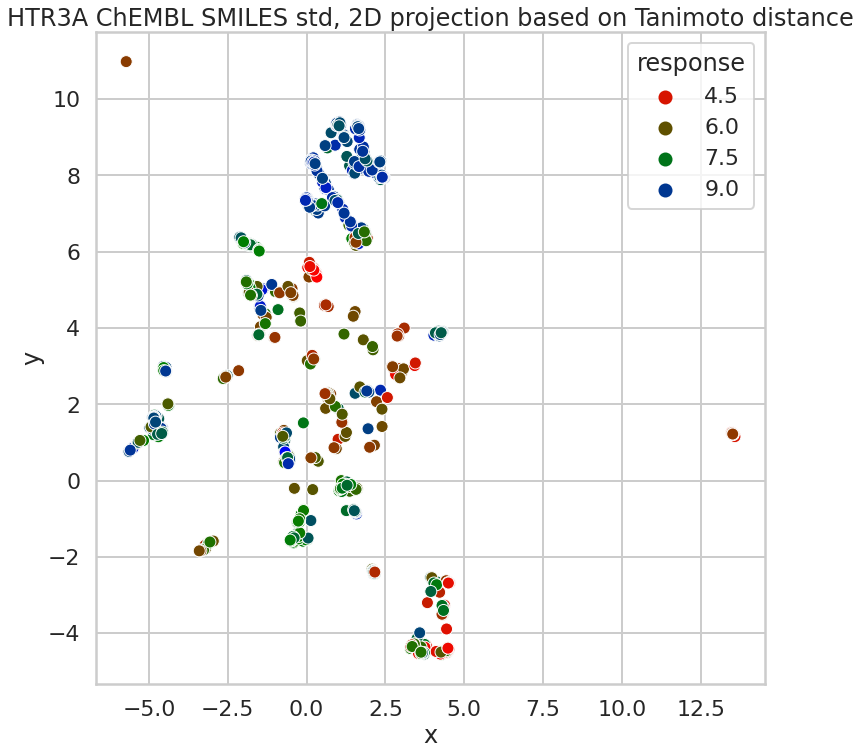

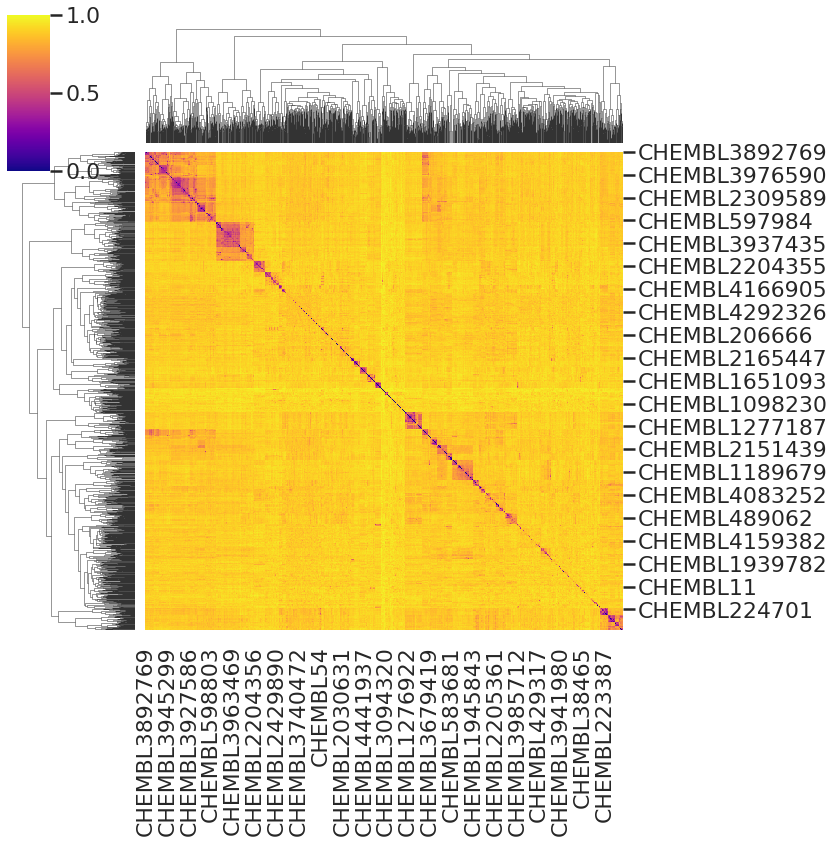

In [91]:
dp.diversity_plots(dset_key='/content/drive/MyDrive/AMPL_EDA_07/HTR3A_ChEMBL_SMILES_std.csv',
                   datastore=False, 
                   id_col ='Molecule_ChEMBL_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pChEMBL_Value')

## Create plots for DTC, Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

In [92]:
dtc['base_rdkit_smiles']

0       COc1cccc(CN2CCN(C3CCC(O)(c4ccc5c(c4)OCO5)CC3)C...
1                                  c1cncc(CN2C3CCC2CC3)c1
2       COc1ccc(-c2c(C#N)c(C(=O)NN3CCCCC3)nn2-c2ccccc2...
3                            NC(=O)N1c2ccccc2C=Cc2ccccc21
4       C[C@H]1Cc2c([nH]c3cc(Cl)c(F)cc23)[C@@]2(N1)C(=...
                              ...                        
1305                Cc1nc(SCc2ccccc2)c2cc(-c3ccccc3)sc2n1
1306                     CC(=O)CSc1ncnc2sc(-c3ccccc3)cc12
1307               O=Cc1ccc(Oc2ncnc3sc(-c4ccccc4)cc23)cc1
1308                                CNc1ncnc2sc(C)c(C)c12
1309                                   CSc1ncnc2sc(C)cc12
Name: base_rdkit_smiles, Length: 1305, dtype: object

In [93]:
# Because we made some changes to DTC. We need to get the std SMILES again

In [94]:
# dtc['base_rdkit_smiles'] = dtc.SMILES.apply(curate_data.base_smiles_from_smiles)
# dtc.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_DTC_SMILES_std.csv")

In [95]:
# dtc=pd.read_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_DTC_SMILES_std.csv", index_col=0)

In [96]:
# dtc.head()

array([0.7761194 , 0.84536082, 0.89473684, ..., 0.63265306, 0.76785714,
       0.71428571])

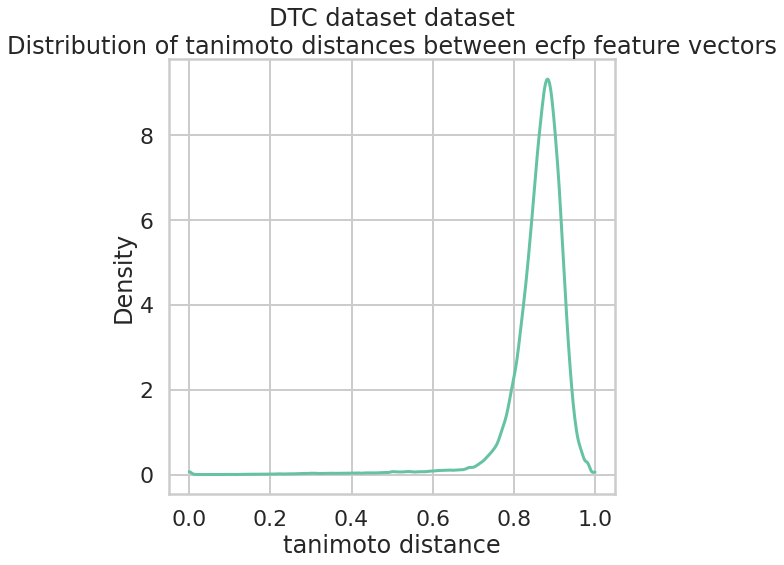

In [97]:
plot_tani_dist_distr(dtc, 'base_rdkit_smiles', 'DTC dataset') # check for NA or other types

In [98]:
dtc[['Compound_ID','base_rdkit_smiles','pDTC_Value']]

Compound_ID                                  base_rdkit_smiles  \
0      CHEMBL100086  COc1cccc(CN2CCN(C3CCC(O)(c4ccc5c(c4)OCO5)CC3)C...   
1      CHEMBL104700                             c1cncc(CN2C3CCC2CC3)c1   
2     CHEMBL1079079  COc1ccc(-c2c(C#N)c(C(=O)NN3CCCCC3)nn2-c2ccccc2...   
3         CHEMBL108                       NC(=O)N1c2ccccc2C=Cc2ccccc21   
4     CHEMBL1082723  C[C@H]1Cc2c([nH]c3cc(Cl)c(F)cc23)[C@@]2(N1)C(=...   
...             ...                                                ...   
1305            NaN              Cc1nc(SCc2ccccc2)c2cc(-c3ccccc3)sc2n1   
1306            NaN                   CC(=O)CSc1ncnc2sc(-c3ccccc3)cc12   
1307            NaN             O=Cc1ccc(Oc2ncnc3sc(-c4ccccc4)cc23)cc1   
1308            NaN                              CNc1ncnc2sc(C)c(C)c12   
1309            NaN                                 CSc1ncnc2sc(C)cc12   

      pDTC_Value  
0            4.0  
1            NaN  
2           50.0  
3           50.0  
4            5.0  
...          ...  
1305         4.0  
1306         4.0  
1307         4.0  
1308         4.0  
1309         4.0  

[1305 rows x 3 columns]

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


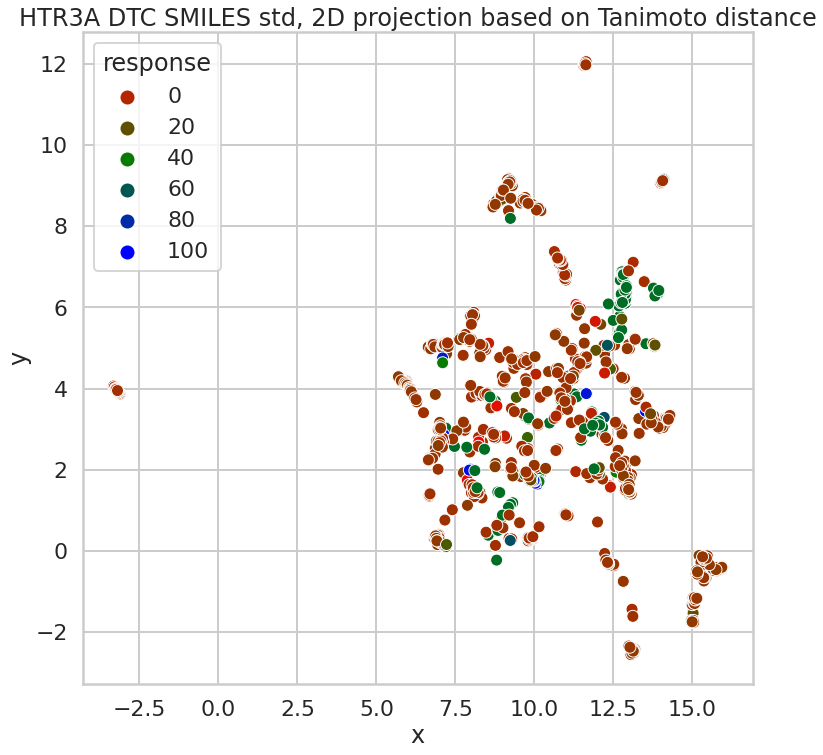

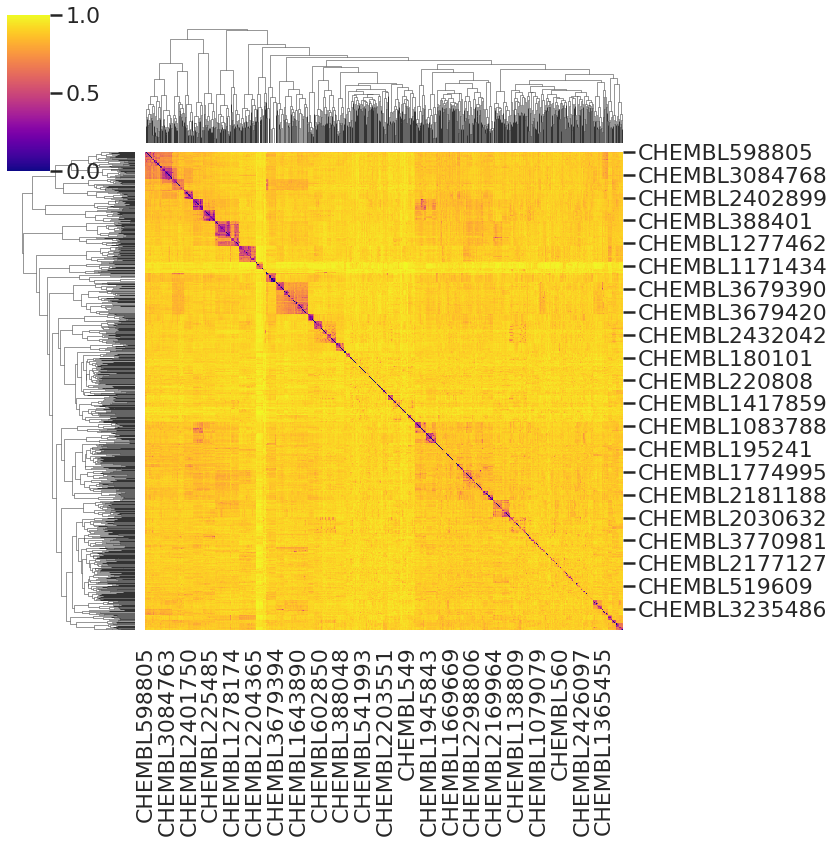

In [99]:
dp.diversity_plots('/content/drive/MyDrive/AMPL_EDA_07/HTR3A_DTC_SMILES_std.csv',
                   datastore=False, 
                   id_col ='Compound_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pDTC_Value')

array([0.86842105, 0.90789474, 0.40983607, ..., 0.22058824, 0.77777778,
       0.77777778])

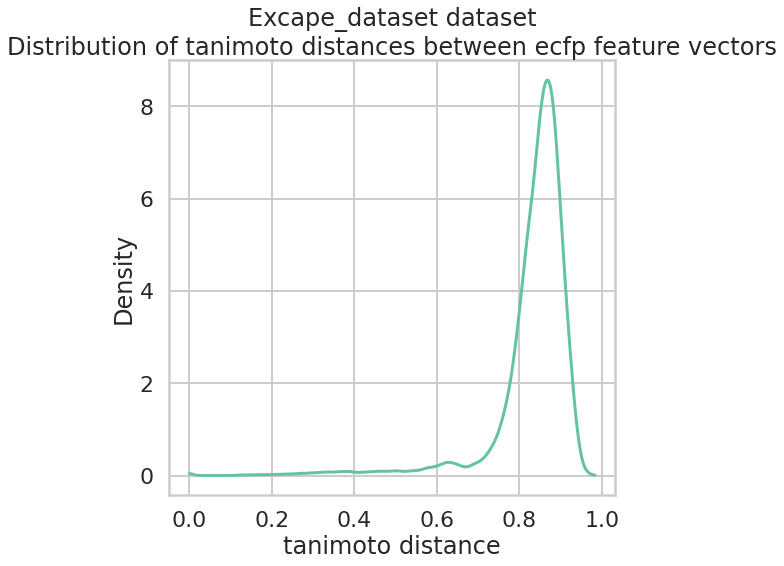

In [100]:
plot_tani_dist_distr(excape, 'base_rdkit_smiles', 'Excape_dataset')

In [101]:
excape.columns


Index(['Ambit_InchiKey', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES', 'base_rdkit_smiles'],
      dtype='object')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


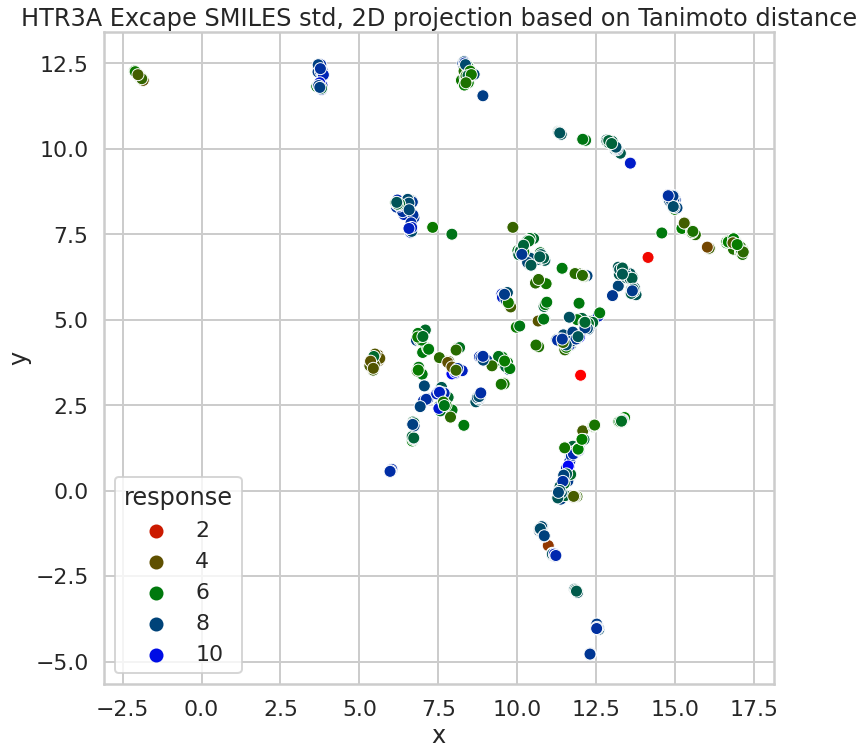

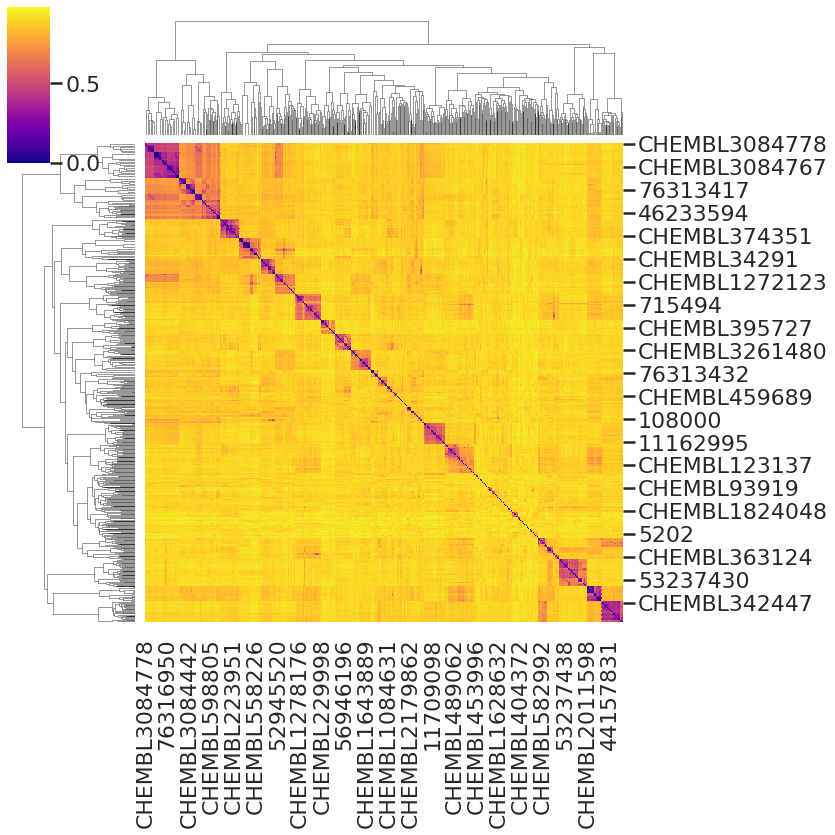

In [102]:
dp.diversity_plots('/content/drive/MyDrive/AMPL_EDA_07/HTR3A_Excape_SMILES_std.csv',
                   datastore=False, 
                   id_col ='Original_Entry_ID', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50')

## Discussion on the analysis of the heatmap and density plots
```
what are Morgan fingerprints (ecfp)? 
what does radius mean?
what does a bit in an ECFP vector correspond to?
what radius and vector length are used in these functions?
hint: look at the .py files for more info
```
ECFP fingerprints are a bit vector representation of a compound's structure. Each bit represents the presence or absence of a certain 'connectivity' between atoms in a molecule. The radius used in the diversity plots function is radius 4 and length 1024. The tanimoto plot function uses radius 2. Radius means number of atoms you travel away from the given atom to assess connectivity, allowing you to look at larger or smaller molecule fragments.


```
what is tanimoto distance? What do values closer to zero or closer to one mean?
Do you think your sets of compounds are diverse?
What do you observe from the 2D projection of compounds?
Are there any similarities between groups of compounds in your datasets?
```

Tanimoto similarity (or jaccard index) represents how well two bit vectors overlap. Thus, distance represents how 'far' away they are from perfect overlap. A distance closer 1 means the fingerprints (and therefore molecules) are less similar to each other. A distance closer to zero means molecules are more similar. 

Compounds that are shown in this exercise have average tanimoto distances ~ 0.85 - 0.9, so they are fairly diverse.

In the ChEMBL dataset, the 2D project separates high and low pChEMBL values very well. The DTC and Excape datasets don't separate as well, but DTC also is on a very different scale.

From the heatmap, we can see clusters/squares of compounds with tanimoto distance closer to zero (purple) so I suspect there are some groups of compounds that are very similar.


# EDA: Curated data
- First let us curate the data
- Examine new compound overlaps
- Examine final response column distributions
- Filter for 
  - large compounds
  - too high / too low pXC50 values
- double check for no NA values left
- save final curated dataset for further processing

Start here if you want to restart from here. Dont forget to uncomment the following code chunk

In [103]:
# chembl=pd.read_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_ChEMBL_SMILES_std.csv", index_col=0)
# dtc=pd.read_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_DTC_SMILES_std.csv", index_col=0)
# excape=pd.read_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_Excape_SMILES_std.csv", index_col=0)

In [104]:
# rescue NA pChemblValues
chembl['pChEMBL_Value_nM'] = -np.log10(chembl.Standard_Value_nM/1000000000)


In [105]:
chembl.head(3)

Molecule_ChEMBL_ID Molecule_Name  Molecule_Max_Phase  Molecular_Weight  \
0      CHEMBL3233676           NaN                 0.0            622.85   
1          CHEMBL773       GLYCINE                 4.0             75.07   
2      CHEMBL3261486           NaN                 0.0            312.37   

   #RO5_Violations  AlogP Compound_Key  \
0              2.0   6.84          22a   
1              0.0  -0.97      glycine   
2              0.0   0.88            9   

                                              Smiles Standard_Type  \
0  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...    Inhibition   
1                                           NCC(=O)O          EC50   
2    O=C1c2cccc3[nH]c(=O)n(c23)CCN1[C@@H]1CN2CCC1CC2      Activity   

  Standard_Relation  Standard_Value Standard_Units  pChEMBL_Value  \
0               '='           13.75              %            NaN   
1               NaN             NaN            NaN            NaN   
2               '='           83.00              %            NaN   

  Data_Validity_Comment         Comment    Uo_Units  Ligand_Efficiency_BEI  \
0                   NaN             NaN  UO_0000187                    NaN   
1                   NaN  Not Determined         NaN                    NaN   
2                   NaN             NaN  UO_0000187                    NaN   

   Ligand_Efficiency_LE  Ligand_Efficiency_LLE  Ligand_Efficiency_SEI  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   

   Potential_Duplicate Assay_ChEMBL_ID  \
0                False   CHEMBL3240658   
1                False    CHEMBL896288   
2                False   CHEMBL3268498   

                                   Assay_Description Assay_Type BAO_Format_ID  \
0  Reversible inhibition of human 5-HT3A expresse...          B   BAO_0000219   
1  Antagonist activity at human 5HT3A receptor ex...          F   BAO_0000219   
2  Partial agonist activity at human 5-HT3A recep...          B   BAO_0000219   

           BAO_Label Assay_Organism Assay_Tissue_ChEMBL_ID Assay_Tissue_Name  \
0  cell-based format   Homo sapiens                    NaN               NaN   
1  cell-based format   Homo sapiens                    NaN               NaN   
2  cell-based format   Homo sapiens                    NaN               NaN   

  Assay_Cell_Type  Assay_Subcellular_Fraction Assay_Parameters  \
0             NaN                         NaN              NaN   
1          HEK293                         NaN              NaN   
2          HEK293                         NaN              NaN   

  Assay_Variant_Accession Assay_Variant_Mutation Target_ChEMBL_ID  \
0                     NaN                    NaN       CHEMBL1899   
1                     NaN                    NaN       CHEMBL1899   
2                     NaN                    NaN       CHEMBL1899   

                      Target_Name Target_Organism     Target_Type  \
0  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   
1  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   
2  Serotonin 3a (5-HT3a) receptor    Homo sapiens  SINGLE PROTEIN   

  Document_ChEMBL_ID  Source_ID     Source_Description  \
0      CHEMBL3232706          1  Scientific Literature   
1      CHEMBL1148788          1  Scientific Literature   
2      CHEMBL3259590          1  Scientific Literature   

           Document_Journal  Document_Year Cell_ChEMBL_ID Properties  \
0        Eur. J. Med. Chem.         2014.0            NaN        NaN   
1             J. Med. Chem.         2007.0  CHEMBL3307715        NaN   
2  Bioorg. Med. Chem. Lett.         2014.0  CHEMBL3307715        NaN   

   Standard_Value_nM                                  base_rdkit_smiles  \
0              13.75  CC1(C)C(=O)N(Cc2ccc(Cl)cc2Cl)C(=O)N1CCCCCN1CCN...   
1                NaN                                      

In [106]:
chembl.Standard_Type.unique()

array(['Inhibition', 'EC50', 'Activity', 'IC50', 'Ki', 'Vmax',
       '% Inhibition of Control Specific Binding (Mean n=2)', 'Ka',
       'pIC50', 'Emax', 'Kd', 'pKi', 'Kb', 'Selectivity ratio',
       'Efficacy', '% Ctrl'], dtype=object)

In [107]:
# select pIC50 values
vals = ['EC50', 'IC50', 'pIC50']
print(chembl.shape)
chembl=chembl[chembl.Standard_Type.isin(vals)]
print(chembl.shape)

(1949, 48)
(602, 48)


In [108]:
# drop NA pIC50's & smiles
chembl=chembl.dropna(axis=0, subset = ['pChEMBL_Value_nM','base_rdkit_smiles'])
print(chembl.shape)

(594, 48)


In [109]:
# note weird punctuation
chembl.Standard_Relation.unique()

array(["'='", "'>'", "'<'"], dtype=object)

In [110]:
# flip arrows and fix punctuation for relation column to reflect pValues not normal values
chembl['pRelation'] = chembl.Standard_Relation
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'<'", ">", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'>'", "<", chembl.pRelation)
chembl['pRelation'] = np.where(chembl.Standard_Relation == "'='", "=", chembl.pRelation)
chembl[['Standard_Relation', 'pRelation']].head()

Standard_Relation pRelation
3               '='         =
4               '>'         <
5               '='         =
6               '>'         <
7               '>'         <

In [111]:
thresh=-np.log10(100/1000000000) # pIC50 of 100nM for threshold

In [112]:
print(chembl.shape)
chembl_cur = curate_data.aggregate_assay_data(chembl, value_col = 'pChEMBL_Value_nM', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Molecule_ChEMBL_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
print(chembl_cur.shape)
chembl_cur.head()

(594, 49)
0 entries in input table are missing SMILES strings
517 unique SMILES strings are reduced to 517 unique base SMILES strings
(517, 5)


compound_id                                  base_rdkit_smiles relation  \
0   CHEMBL583681  COc1cccc([C@@]2(O)CCCC[C@@H]2CN2CC[C@@H](NC(=O...            
1  CHEMBL3969801         COc1ccc2nc(NC3=NC[C@]4(CN5CCC4CC5)O3)sc2c1        <   
2  CHEMBL3968048        O=C(OC1CCN2CCOC1C2)c1cn(CC(F)F)c2ccc(F)cc12        <   
3  CHEMBL4202588               Cc1cccc2c1nc1n2C[C@@]2(CN3CCC2CC3)O1            
4  CHEMBL4093500    c1ccc(-c2cnc(NC3=NC[C@@]4(CN5CCC4CC5)O3)cn2)cc1        <   

      pXC50  active  
0  5.552842       0  
1  4.013228       0  
2  6.000000       0  
3  8.154902       1  
4  4.000000       0

In [113]:
chembl_cur.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_ChEMBL_cur.csv")

In [114]:
# DTC
# select pIC50 values
vals = ['EC50', 'IC50', 'PIC50']
print(dtc.shape)
dtc=dtc[dtc.End_Point_Standard_Type.isin(vals)]
print(dtc.shape)

# flip arrows for relation column to reflect pValues not normal values
dtc['pRelation'] = dtc.End_Point_Standard_Relation
dtc['pRelation'] = np.where(dtc.End_Point_Standard_Relation == "<", ">", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.End_Point_Standard_Relation == ">", "<", dtc.pRelation)
dtc['pRelation'] = np.where(dtc.End_Point_Standard_Relation == "=", "=", dtc.pRelation)
print(dtc.pRelation.unique())
display(dtc[['End_Point_Standard_Relation', 'pRelation']].head())

dtc=dtc.dropna(axis=0, subset = ['pDTC_Value','base_rdkit_smiles'])
print(dtc.shape)

# aggregate duplicates
dtc_cur = curate_data.aggregate_assay_data(dtc, value_col = 'pDTC_Value', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Compound_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
dtc_cur.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_DTC_cur.csv")
print(dtc_cur.shape)
print(dtc_cur.relation.unique())
dtc_cur.head()

(1305, 46)
(275, 46)
['<' '=' nan '>']


End_Point_Standard_Relation pRelation
0                           >         <
4                           >         <
5                           >         <
6                           >         <
7                           >         <

(267, 47)
0 entries in input table are missing SMILES strings
226 unique SMILES strings are reduced to 226 unique base SMILES strings
(226, 5)
['' '<' '>']


compound_id                                  base_rdkit_smiles relation  \
0   CHEMBL583681  COc1cccc([C@@]2(O)CCCC[C@@H]2CN2CC[C@@H](NC(=O...            
1  CHEMBL3261481           O=C1c2cccc3cnn(c23)CCN1[C@@H]1CN2CCC1CC2            
2  CHEMBL1277282  Nn1c(CCCCN2CCN(c3nc4ccccc4cc3O)CC2)nc2c(c1=O)C...            
3  CHEMBL1084365           COc1ccccc1-c1ccc(NC(=O)NCCCCN2CCCCC2)cn1        <   
4            NaN                Nc1nc(SCc2cccc3ccccc23)c2[nH]cnc2n1            

      pXC50  active  
0  5.552842       0  
1  6.749580       0  
2  7.279014       1  
3  4.522879       0  
4  6.309804       0

In [115]:
# excape: has no relation col, so create one with all ''
excape['pRelation']=''
print(excape.shape)
print(excape.pRelation.unique())
excape=excape.dropna(axis=0, subset = ['pXC50','base_rdkit_smiles'])
print(excape.shape)
# aggregate duplicates
excape_cur = curate_data.aggregate_assay_data(excape, value_col = 'pXC50', 
                                              output_value_col = 'pXC50',
                                              id_col = 'Original_Entry_ID', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'pRelation',
                                              active_thresh=thresh)
excape_cur.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_Excape_cur.csv")
print(excape_cur.shape)
print(excape_cur.relation.unique())
excape_cur.head()

(649, 13)
['']
(645, 13)
0 entries in input table are missing SMILES strings
601 unique SMILES strings are reduced to 600 unique base SMILES strings
(600, 5)
['']


compound_id                                  base_rdkit_smiles relation  \
0       45485675  COc1cccc([C@@]2(O)CCCC[C@@H]2CN2CC[C@@H](NC(=O...            
1       53237896                    Clc1cccc(Sc2ccccc2N2CCNCC2)c1Cl            
2  CHEMBL2169967                          CN1CCN(c2cnc3ccccc3c2)CC1            
3  CHEMBL2402890  CCc1nc2cccc(C(=O)NCC3CCN(CC(O)CN4CCN(S(C)(=O)=...            
4  CHEMBL2180264  O=C(N[C@H]1C2CCN(CC2)[C@@H]1Cc1cccnc1)c1cc2ccc...            

     pXC50  active  
0  5.55284       0  
1  7.17393       1  
2  6.39000       0  
3  4.10000       0  
4  4.40000       0

In [116]:
chembl_cur['datasource'] = 'chembl'
dtc_cur['datasource']='dtc'
excape_cur['datasource']='excape'
HTR3A = pd.concat([chembl_cur, dtc_cur, excape_cur])
HTR3A.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_merge.csv")
print(HTR3A.shape)

(1343, 6)


In [117]:
import importlib
importlib.reload(curate_data)
HTR3A_cur = curate_data.aggregate_assay_data(HTR3A, value_col = 'pXC50', 
                                              id_col = 'compound_id', 
                                              smiles_col = 'base_rdkit_smiles',
                                              relation_col = 'relation',
                                              active_thresh=thresh)

print(HTR3A_cur.shape)
print(HTR3A.relation.unique())
HTR3A_cur.head()

0 entries in input table are missing SMILES strings
1041 unique SMILES strings are reduced to 1041 unique base SMILES strings
(1041, 5)
['' '<' '>']


compound_id                                  base_rdkit_smiles relation  \
0       45485675  COc1cccc([C@@]2(O)CCCC[C@@H]2CN2CC[C@@H](NC(=O...            
1       53237896                    Clc1cccc(Sc2ccccc2N2CCNCC2)c1Cl            
2  CHEMBL3969801         COc1ccc2nc(NC3=NC[C@]4(CN5CCC4CC5)O3)sc2c1        <   
3  CHEMBL3968048        O=C(OC1CCN2CCOC1C2)c1cn(CC(F)F)c2ccc(F)cc12        <   
4            NaN                Nc1nc(SCc2cccc3ccccc23)c2[nH]cnc2n1            

      pXC50  active  
0  5.552841       0  
1  7.173930       1  
2  4.013228       0  
3  6.000000       0  
4  6.309804       0

In [118]:
HTR3A_cur.relation.unique()

array(['', '<'], dtype=object)

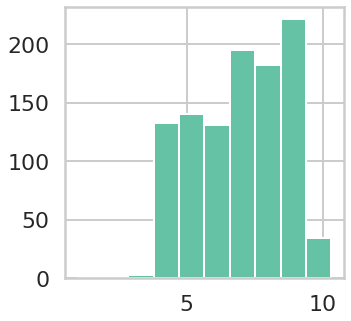

In [119]:
HTR3A_cur.pXC50.hist(figsize=(5,5));

In [120]:
HTR3A_cur.active.sum()

552

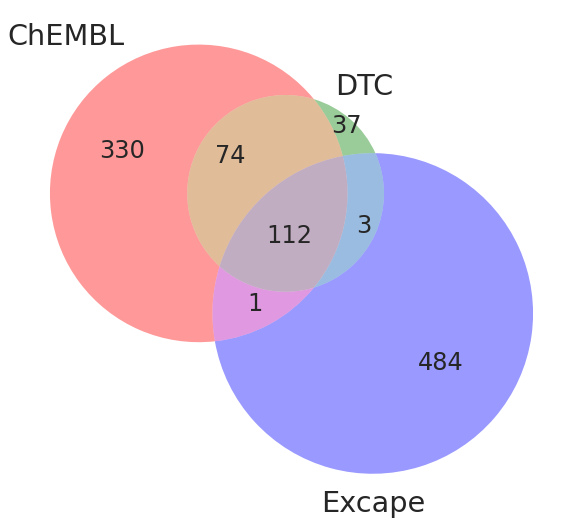

In [121]:
mpv.venn3([set(HTR3A.loc[HTR3A.datasource=='chembl','base_rdkit_smiles']),
           set(HTR3A.loc[HTR3A.datasource=='dtc','base_rdkit_smiles']),
           set(HTR3A.loc[HTR3A.datasource=='excape','base_rdkit_smiles']),],
          set_labels = ['ChEMBL','DTC','Excape']);

2021-08-10 18:13:19,383 *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


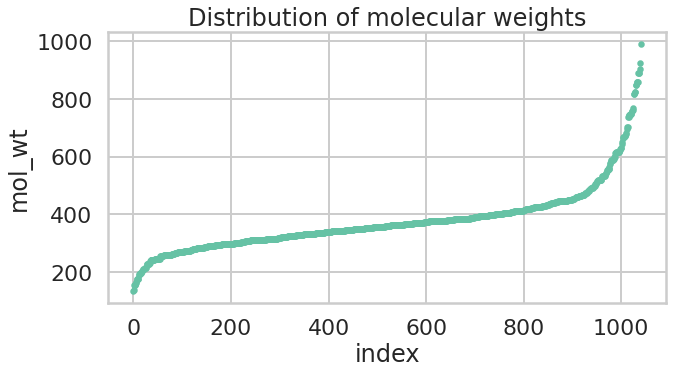

In [122]:
HTR3A_cur["mol_wt"] = [Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smile)) for smile in HTR3A_cur["base_rdkit_smiles"]]
HTR3A_cur = HTR3A_cur.sort_values('mol_wt')
HTR3A_cur=HTR3A_cur.reset_index(drop=True)
HTR3A_cur=HTR3A_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(10,5))
HTR3A_cur.plot(kind='scatter', x='index', y='mol_wt', ax=ax);
plt.title("Distribution of molecular weights");

In [123]:
print(HTR3A_cur.shape)
HTR3A_cur = HTR3A_cur[HTR3A_cur.mol_wt <1400]
print(HTR3A_cur.shape)

(1041, 7)
(1041, 7)


2021-08-10 18:13:19,726 *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


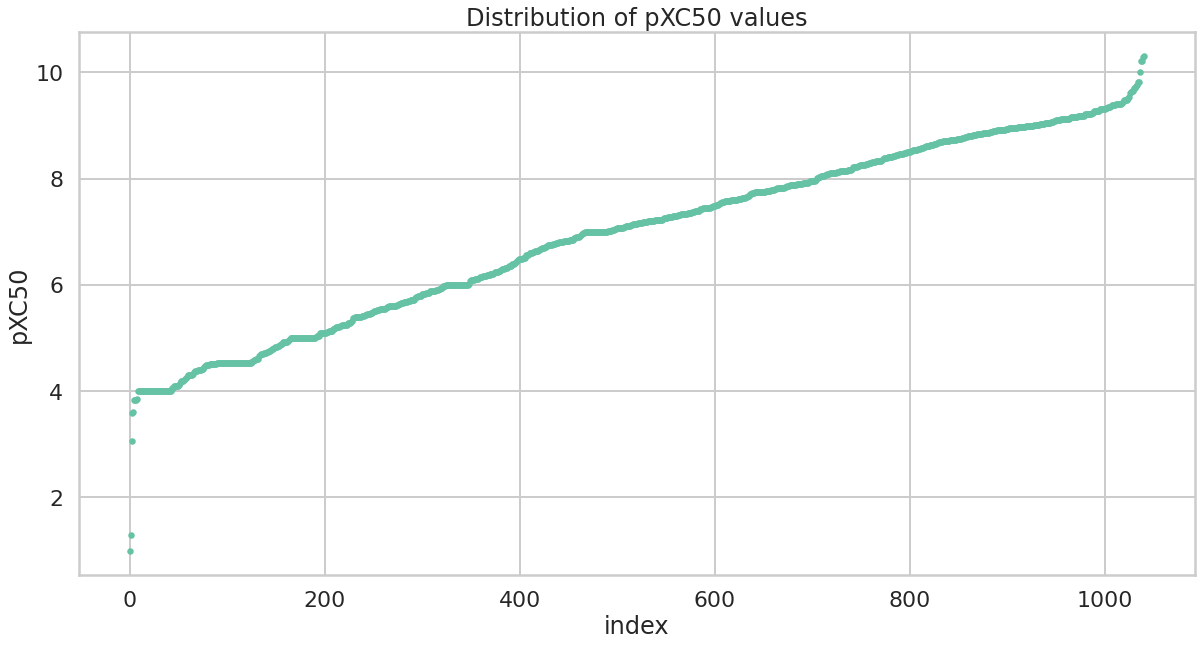

In [124]:
HTR3A_cur=HTR3A_cur.drop(columns=['index'])
HTR3A_cur = HTR3A_cur.sort_values('pXC50')
HTR3A_cur = HTR3A_cur.reset_index(drop=True)
HTR3A_cur = HTR3A_cur.reset_index() # plot x axis as index #'s
fig,ax=plt.subplots(figsize=(20,10))
HTR3A_cur.plot(kind='scatter', x='index', y='pXC50', ax=ax);
plt.title("Distribution of pXC50 values");

In [125]:
print(HTR3A_cur.shape)
HTR3A_cur=HTR3A_cur[HTR3A_cur.pXC50>2]
HTR3A_cur=HTR3A_cur[HTR3A_cur.pXC50<14]
print(HTR3A_cur.shape)

(1041, 7)
(1039, 7)


In [126]:
for col in HTR3A_cur.columns:
  print(col, HTR3A_cur[col].isna().values.any())

index False
compound_id True
base_rdkit_smiles False
relation False
pXC50 False
active False
mol_wt False


array([0.94444444, 0.88888889, 0.94642857, ..., 0.83950617, 0.83950617,
       0.85294118])

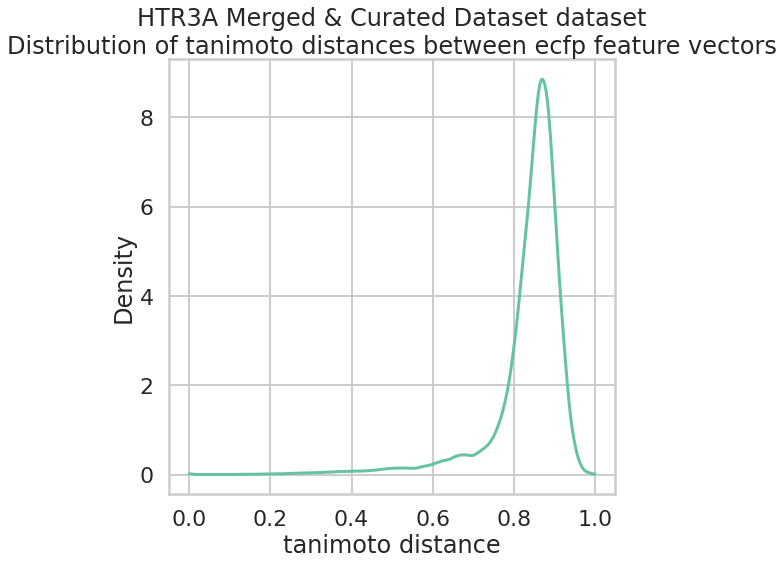

In [127]:
plot_tani_dist_distr(HTR3A_cur, 'base_rdkit_smiles', 'HTR3A Merged & Curated Dataset')

In [128]:
HTR3A_cur.to_csv("/content/drive/MyDrive/AMPL_EDA_07/HTR3A_cur.csv")

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


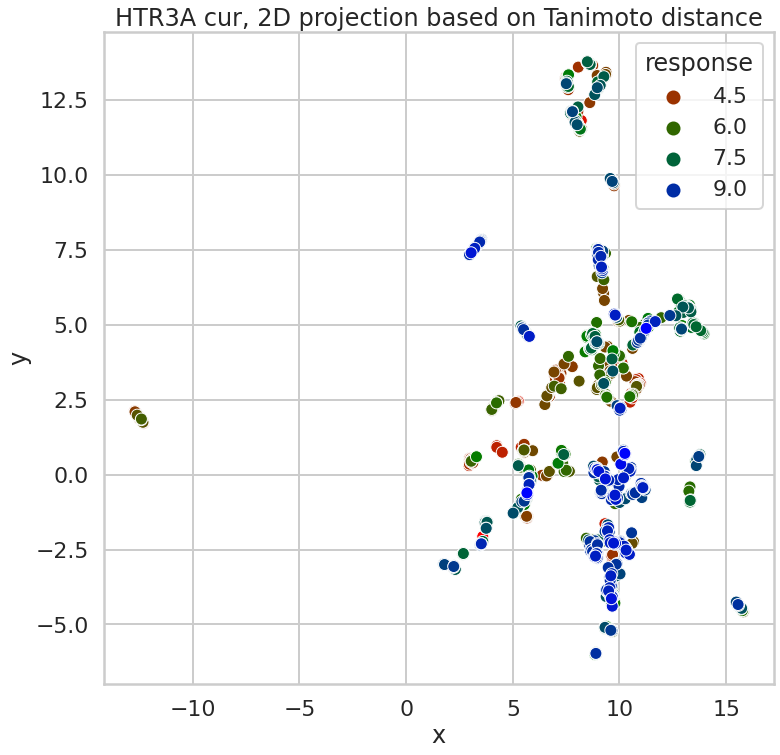

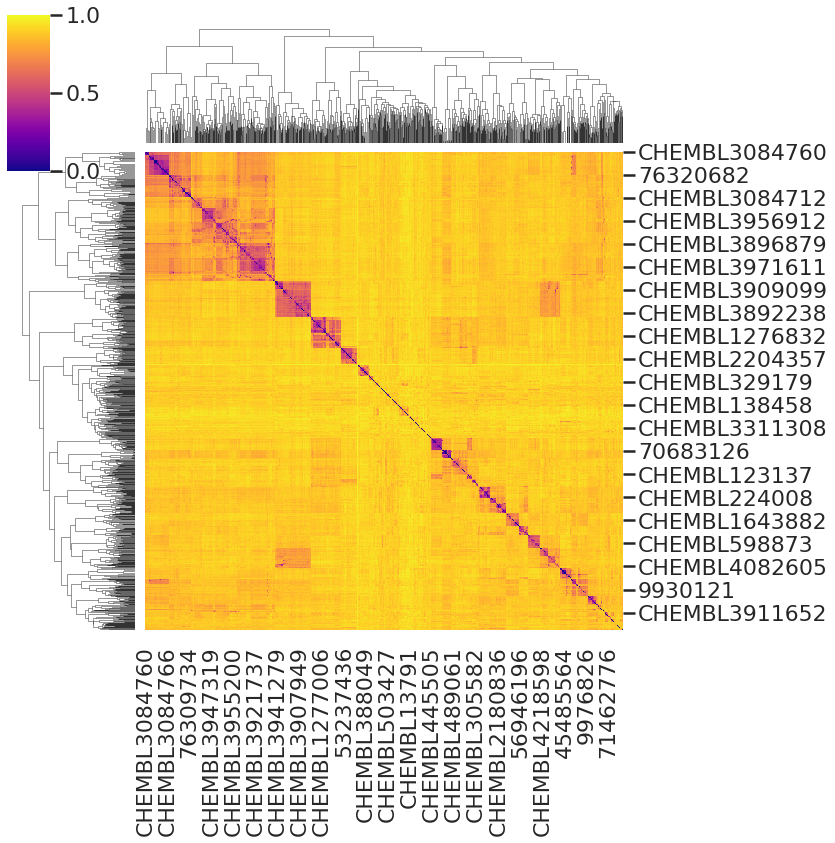

In [129]:
dp.diversity_plots('/content/drive/MyDrive/AMPL_EDA_07/HTR3A_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


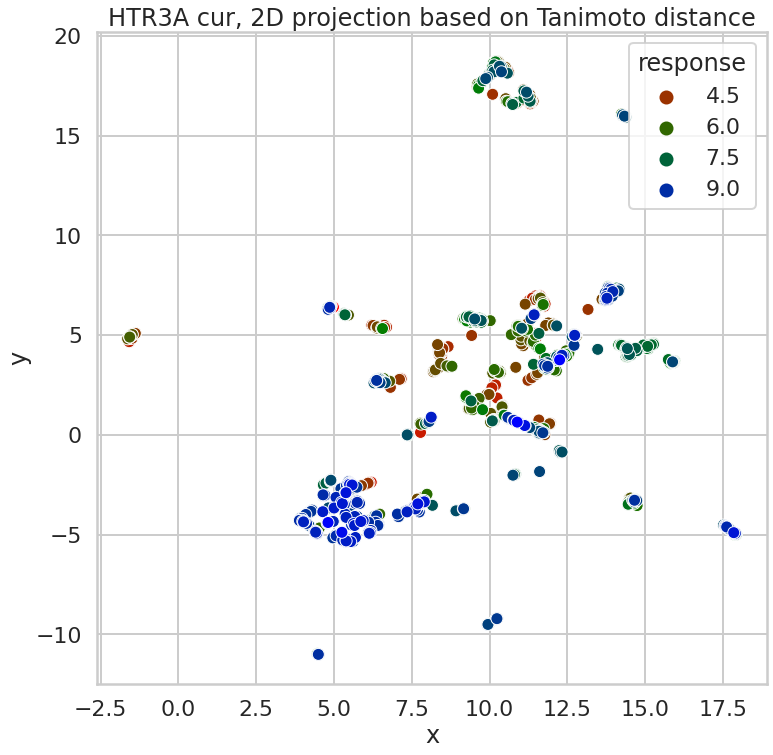

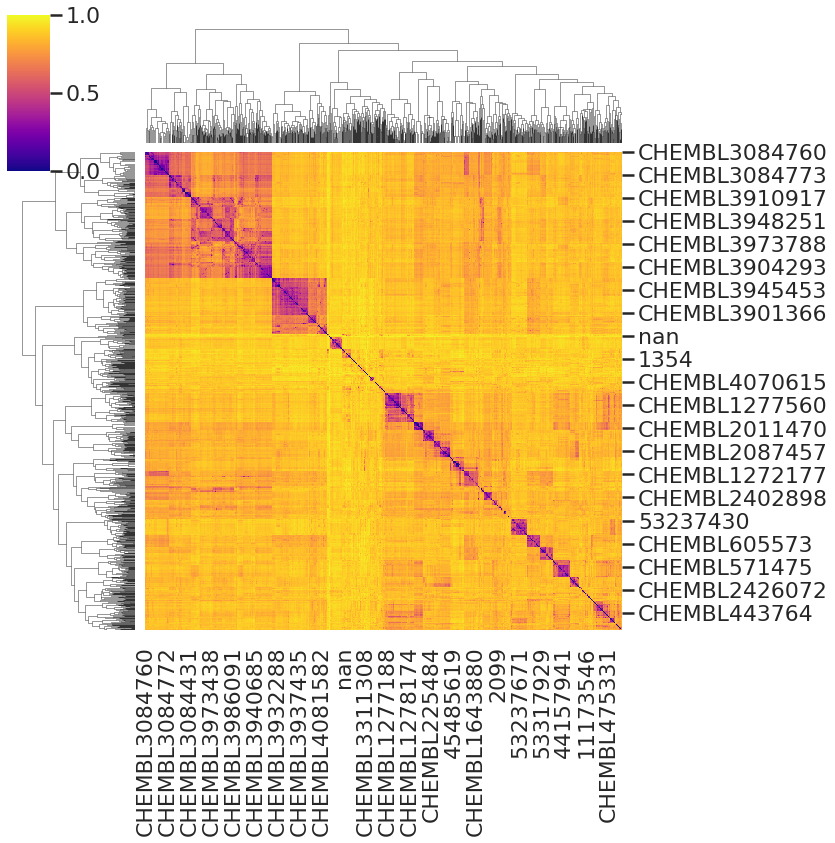

In [130]:
dp.diversity_plots('/content/drive/MyDrive/AMPL_EDA_07/HTR3A_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50',
                   ecfp_radius = 2)

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


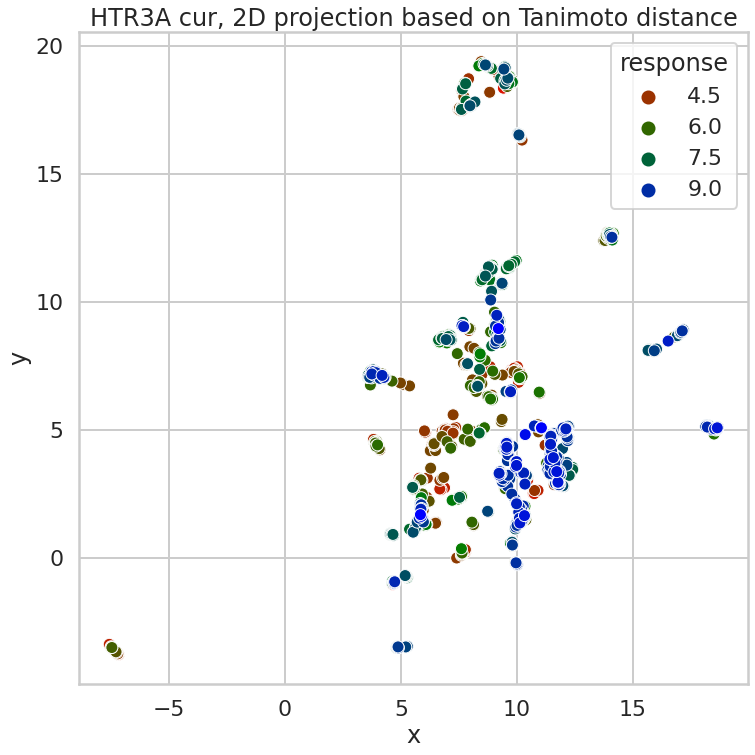

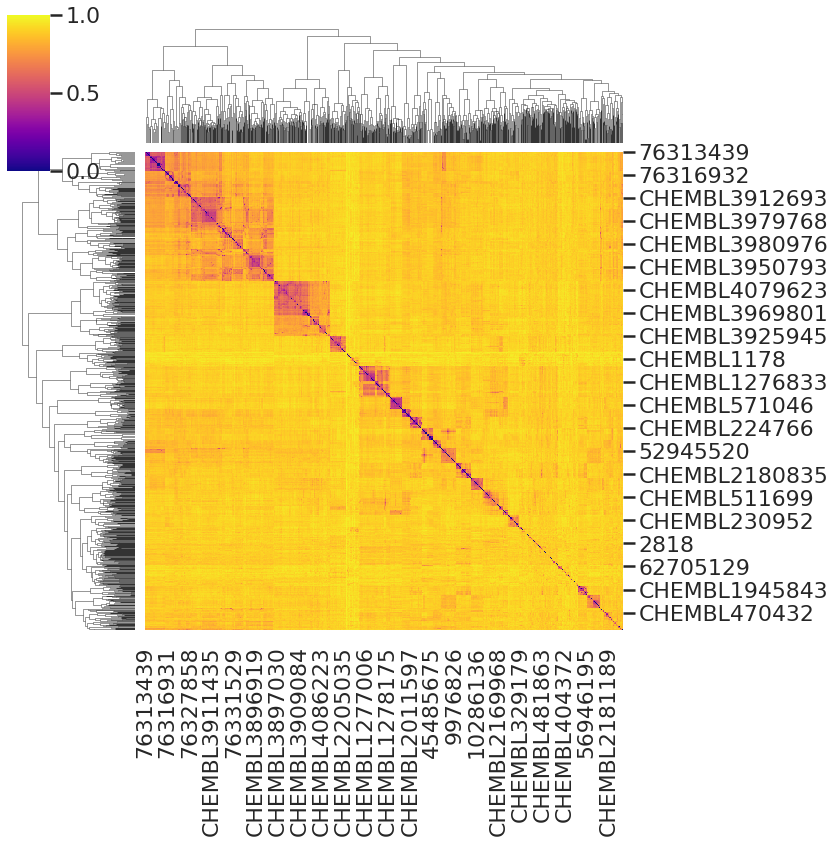

In [131]:
dp.diversity_plots('/content/drive/MyDrive/AMPL_EDA_07/HTR3A_cur.csv', 
                   datastore = False,
                   id_col ='compound_id', 
                   smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, 
                   response_col = 'pXC50',
                   ecfp_radius = 6)

The following code takes too long. Try only when you are running this
on a dedicated server

In [132]:
# warning: max_for_mcs = 1100, takes too long on COLAB
importlib.reload(dp)
# dp.diversity_plots('/content/drive/MyDrive/AMPL_EDA_07/HTR3A_cur.csv', 
#                    id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
#                    is_base_smiles=True, response_col = 'pXC50', 
#                    max_for_mcs=1100)

<module 'atomsci.ddm.pipeline.diversity_plots' from '/usr/local/lib/python3.7/dist-packages/atomsci/ddm/pipeline/diversity_plots.py'>

# Now you're ready to move on to the next stage of EDA & modeling: featurizing datasets
- featurize with structure-based fingerprints like ECFP
- or molecular descriptor sets like RDKit and Mordred
- these are high - dimensional datasets (200-2000 features or 'dimensions')
- so UMAP, tSNE and other dimensionality reduction techniques will help visualize the 'chemical space' of the dataset

In [133]:
!date

Tue Aug 10 18:13:50 UTC 2021
